In [1]:
import time
import os
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import *
import cvxopt as opt
from cvxopt import blas, solvers
import calendar
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import History 
from keras.models import load_model
from keras.models import model_from_json

def getRusselReturn():
    # from https://fred.stlouisfed.org/series/RU3000PR#0
    # Download russell 300 index monthly returns data from 1977-2017
    russ3000_ret = pd.read_csv('./data/russell3000.csv', header = 0, names = ['DATE','MONTHLY RET'])
    russ3000_ret['MONTHLY RET'] = russ3000_ret['MONTHLY RET'] /100 
    return russ3000_ret

def getAnnualReturns(returns):
    annret = []
    for i in range(len(returns)):
        if (i+1)%12 == 0:
            annret.append(np.sum(returns[i-11:i+1]))
    return annret


def getInformationRatio(returns):
    annret =getAnnualReturns(returns)
    stddev = np.std(annret)
    return np.sum(annret)/ (stddev * len(annret))

def maxDrawDown(returns):
    mdd_list = []
    index = 0
    next_peak_index = index+1
    peak = returns[0]
    while index < len(returns) and next_peak_index < len(returns) -1:
        next_peak_index = index+1
        if peak < returns[next_peak_index]:
            peak = returns[next_peak_index]
            index = index +1
        else:
            trough = returns[next_peak_index]
            mdd_list.append( (trough - peak) / peak)
            index = index +1
        
    return min(mdd_list) 

def columnToFloat(table,colname):
    #This function will take a column in a data frame that has numbers stored as strings and convert them to floats
    sample_name = list(table[colname])
    sample_name = list(map(float, sample_name))
    return sample_name


def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year,month)[1])
    return date(year,month,day)


def getFactordata():
    #Read in the total_data5 set, IT's MASSIVE
    totalset = pd.read_csv('./data/Total_Data5.csv')
    totalset = totalset[['DATE','TICKER','mcap','EP','BP','CP','SP','ES','RET','CRET','REP','RBP','RCP','RSP','CTEF','PM1', 'BR2','VOL','TOT','MRV1']]
    totalset = totalset.drop_duplicates(subset = ['DATE','TICKER'],keep='first')
    #Remove missing values from data
    totalset = totalset[totalset['ES'] != '.']
    totalset = totalset[totalset['CTEF'] != '.']
    totalset = totalset[totalset['PM1'] != '.']
    #RET is in percent, put in decimal
    totalset['RET'] = totalset['RET']/100
    totalset = totalset.reset_index()
    totalset = totalset.iloc[:,1:]
    totalset['ES'] = columnToFloat(totalset,'ES')
    totalset['CTEF'] = columnToFloat(totalset,'CTEF')
    totalset['PM1'] = columnToFloat(totalset,'PM1')
    totalset = totalset.replace('.', np.NaN)
    cols = ['BR2','VOL','TOT','MRV1']
    totalset[cols] = totalset[cols].ffill()
    totalset = totalset.dropna()
    return totalset
    
def filterUnivTotalSet(totalset,DATE):

    #Important for part 3
    totalset_sub = totalset[totalset['DATE'] == DATE] #whatever format its in
    totalset_sub = totalset_sub.reset_index()
    totalset_sub = totalset_sub.iloc[:,1:]
    
    #PART 2 - A
    #Rank by mcap, then collect top 4000
    totalset_sub = totalset_sub.sort_values(['mcap'], ascending=False)
    totalset_sub = totalset_sub.iloc[:4000,:] 
    
    #PART 2 - B
    #Eli Schwartz
    #Choose 70th percentile and above for ES value from totalset_sub
    totalset_sub = totalset_sub.sort_values(['ES'], ascending=False)
    
    n=len(totalset_sub)
    index= int(n*7/10) #70th percentile
    totalset_sub = totalset_sub.iloc[index:,:]
    
    #Reset index
    totalset_sub = totalset_sub.reset_index()
    totalset_sub = totalset_sub.iloc[:,1:]
    
    return totalset_sub


def subtractYear(dateCons, year):
    year = dateCons.year - year
    month = dateCons.month
    day =  dateCons.day
    dateString = str(month) + "/" + str(day) + "/" + str(year)
    yearBackDate = datetime.strptime(dateString, '%m/%d/%Y')
    return yearBackDate

def getExcessReturn(dateCons, totalset,filteredTotalSet, russ3000):
    dateRLow = subtractYear(dateCons, 2)
    russ3000['DATE']= pd.to_datetime(russ3000['DATE'])
    indexFrame = russ3000[(russ3000['DATE'] > dateRLow ) & (russ3000['DATE'] <= dateCons)]
    indexFrame = indexFrame.drop_duplicates(subset =['DATE', 'MONTHLY RET'],keep='first')
    indexFrame = indexFrame.sort_values(by='DATE')
    indexFrame = indexFrame.set_index('DATE')
    
    stockFrame = pd.DataFrame(index = indexFrame.index)
    rangeFrame = totalset[(totalset['DATE'] > dateRLow ) & (totalset['DATE'] <= dateCons)]

    for i in range(filteredTotalSet.shape[0]):
    #for i in range(4):
        smallF = rangeFrame[rangeFrame['TICKER'] == filteredTotalSet.iloc[i]['TICKER']]
        smallF = smallF[['DATE', 'CRET']]
        smallF = smallF.drop_duplicates(subset =['DATE', 'CRET'],keep='first')
        smallF = smallF.sort_values(by='DATE')
        smallF = smallF.rename(columns = {'CRET': filteredTotalSet.iloc[i]['TICKER']})
        smallF = smallF.set_index('DATE')
        smallF[filteredTotalSet.iloc[i]['TICKER']] = smallF[filteredTotalSet.iloc[i]['TICKER']] - indexFrame['MONTHLY RET']
        stockFrame = stockFrame.join(smallF)
    
    return stockFrame


def runRegression(xVar, yVar, toPrint):
    xVar = sm.add_constant(xVar, has_constant='add') #neat
    model = sm.OLS(yVar.astype(float), xVar.astype(float))
    result = model.fit()
    if(toPrint):
        print(result.summary())
    return result.params

def coeffSig(coeff_frame):
        avg_betas_part3 = []
        std_betas_part3 = []
        sign_betas_part3 = []
        
        for name in list(coeff_frame):
            avg = np.average(coeff_frame[name])
            avg_betas_part3.append(avg)
            std_ = np.std(coeff_frame[name])
            std_betas_part3.append(std_)
            if std_ == 0:
                sign_betas_part3.append(0)
            else:
                sign_betas_part3.append(avg/(std_/sqrt(len(coeff_frame[name]))))
        
        betaData = pd.DataFrame({ 'Coeff' : list(coeff_frame),
                                  'Average': avg_betas_part3,
                                  'Stdev': std_betas_part3,
                                  'Significance': sign_betas_part3
                                })
        betaData.set_index('Coeff', inplace=True)
        
        return betaData

def prepRegression(dateCons, totalset, tickerList):
    datePrevYear = subtractYear(dateCons, 1)
    datePrevYear = add_months(datePrevYear, 1)
    df = pd.DataFrame()
    for i in range(12):
        dateNext = add_months(datePrevYear, 1)
        retNextPeriod = totalset[totalset['DATE'] == dateNext]
        smallFil = totalset[totalset['DATE'] == datePrevYear] 
        retNextPeriod = retNextPeriod[['TICKER', 'CRET']]
        retNextPeriod = retNextPeriod.loc[retNextPeriod.TICKER.isin(tickerList)]
        factorList = ['TICKER','EP','BP','CP','SP','REP','RBP','RCP','RSP','CTEF','PM1']
        smallFil =  smallFil[factorList]
        smallFil =  smallFil.loc[smallFil.TICKER.isin(tickerList)]
        dfRegression = pd.merge(retNextPeriod, smallFil, on='TICKER')
        yVar = dfRegression[['CRET']]
        xVar = dfRegression[factorList]
        del xVar['TICKER']
        result = runRegression(xVar, yVar, False)
        df = df.append(result.to_frame().T)
        datePrevYear = dateNext
    return coeffSig(df)
    
def getERetCovar(xsRetFrame, dateCons, dfRegression, totalset, tickerList):
    xsRetFrame = xsRetFrame.fillna(0)
    dateNext = add_months(dateCons, 1)
    factorDataNext= totalset[(totalset['DATE'] == dateNext )]
    listOfFactors = ['TICKER','EP','BP','CP','SP','REP','RBP','RCP','RSP','CTEF','PM1']
    factorDataNext = factorDataNext[listOfFactors]
    factorDataNext = factorDataNext.loc[factorDataNext.TICKER.isin(tickerList)]
    xsRetFrame = xsRetFrame[factorDataNext.TICKER]
    erVector = factorDataNext.ix[:, 'EP':]
    factorCoef = dfRegression.ix['EP':,0:1]['Average'].T
    erVector = erVector.mul(factorCoef).sum(axis=1) 
    
    erVector[:] += dfRegression.ix[:'const',0:1]['Average'].values[0]
    erVector.fillna(0, inplace = True)
    xsRetFrame.fillna(0, inplace = True)
    return erVector, xsRetFrame.cov(),factorDataNext.TICKER

def getCtef(totalset, dateCons, tickerList, stockFrame):
    stockFrame = stockFrame.fillna(0)
    ctef = totalset[(totalset['DATE'] == dateCons)] 
    ctef = ctef[['TICKER', 'CTEF']]
    ctef = ctef.loc[ctef.TICKER.isin(tickerList)]
    stockFrame = stockFrame[ctef.TICKER]
    stockFrame.fillna(0, inplace = True)
    ctef.fillna(0, inplace = True)
    return ctef[['CTEF']], stockFrame.cov(), stockFrame.columns

def splitTrainTest(dataset, testSize):
    y = dataset.iloc[:, 0:1]
    data = dataset.iloc[:, 1:7]
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.4)
    return  X_train, X_test, y_train, y_test


def getTrainingFrame(dateCons, totalset, tickList10Fac):
    datePrevYear = subtractYear(dateCons, 5)
    datePrevYear = add_months(datePrevYear, 1)
    df = pd.DataFrame()
    for i in range(120):
        dateNext = add_months(datePrevYear, 1)
        retNextPeriod = totalset[totalset['DATE'] == dateNext]
        smallFil = totalset[totalset['DATE'] == datePrevYear] 
        retNextPeriod = retNextPeriod[['TICKER', 'CRET']]
        retNextPeriod = retNextPeriod.loc[retNextPeriod.TICKER.isin(tickList10Fac)]
        factorList = ['TICKER','BR2','PM1','REP','VOL','TOT','MRV1']
        smallFil =  smallFil[factorList]
        smallFil =  smallFil.loc[smallFil.TICKER.isin(tickList10Fac)]
        df = df.append(pd.merge(retNextPeriod, smallFil, on='TICKER'))
        datePrevYear = dateNext
    del df['TICKER']
    return df

def getKnn(dateCons, totalset, tickList):
    df = getTrainingFrame(dateCons, totalset, tickList)
    X_train, X_test, y_train, y_test = splitTrainTest(df, 0.3)
    neigh = KNeighborsRegressor(n_neighbors = 6, algorithm = 'auto', weights = 'uniform')
    neigh.fit(X_train, y_train)
    return neigh
    
    
def getML(totalset, dateCons, tickerList, stockFrame, model):
    stockFrame = stockFrame.fillna(0)
    ml = totalset[(totalset['DATE'] == dateCons)] 
    ml = ml[['TICKER','BR2','PM1','REP','VOL','TOT','MRV1']]
    ml = ml.loc[ml.TICKER.isin(tickerList)]
    stockFrame = stockFrame[ml.TICKER]
    ml = ml[['BR2','PM1','REP','VOL','TOT','MRV1']]
    er = model.predict(ml)
    er = pd.DataFrame(er)
    stockFrame.fillna(0, inplace = True)
    er.fillna(0, inplace = True)
    return er, stockFrame.cov(), stockFrame.columns

def optimizeFunc10Factor(mus,sigma):
    pbar = mus
    pbar= pbar.astype(np.double)
    avg=opt.matrix(np.array(pbar))
    n = pbar.shape[0]
    #print(n)
   #Inequality Constraint - Max Variance
    U,V = np.linalg.eig(sigma)
    Usqrt = np.sqrt(U)
    A = np.dot(np.diag(Usqrt),V.T)
    G1temp = np.zeros((A.shape[0],A.shape[1]))
    G1temp[:,:] = -A
    h1temp = np.zeros((A.shape[0],1))
    h1temp[0] = np.sqrt(0.0064)
   #Inequality Constraint - Lower Bound
    Gtemp = []
    Htemp = []
    for i in range(n):
        eim = opt.matrix(0.,(1,n))
        eim[0,i] = -1.
        Gtemp.append(eim)
        h2temp = opt.matrix(np.zeros((1,1)))
        Htemp.append(h2temp)
   #Inequality Constraint - Upper Bound
    for i in range(n):
        eim2 = opt.matrix(0.,(1,n))
        eim2[0,i] = 1.
        Gtemp.append(eim2)
        h3temp = opt.matrix(0.1,(1,1))
        Htemp.append(h3temp)
    #Equality Constraint - weights sum to 1
    Ftemp = np.ones((1,n))
    F = opt.matrix(Ftemp)
    g = opt.matrix(np.ones((1,1)))
    #Compile inequality constraints
    G = [opt.matrix(G1temp)] + Gtemp
    H = [opt.matrix(h1temp)] + Htemp

    #Solve QCQP by passing in -matrix(pbar) to maximize
    sol = solvers.socp(-opt.matrix(avg),Gq=G,hq=H,A=F,b=g)
    weights = np.array(sol['x'])
    #constraint tests
#     print('Sum of Weights: ' + str(weights.sum()))
#     print('Max of Weights: ' + str(weights.max()))
#     print('Min of Weights: ' + str(weights.min()))
    print('Portfolio Variance: ' + str(np.dot(weights.T,np.dot(sigma,weights))))
    return weights.T


def computeRealRet(weights, totalset, dateCons, tickerList):
    dateCons = add_months(dateCons, 1)
    retNextPeriod = totalset[(totalset['DATE'] == dateCons)] 
    retNextPeriod = retNextPeriod[['TICKER', 'CRET']]
    retNextPeriod = retNextPeriod.loc[retNextPeriod.TICKER.isin(tickerList)]
    return np.dot(weights, retNextPeriod['CRET'])

def loadNNModel():
    # load json and create model
    json_file = open("./Model/modelNN.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("./Model/NNStockPredictor.h5")
    print("Loaded model from disk")
    return loaded_model

if __name__=='__main__':
    
    resultpath = "Result"
    if(not os.path.isdir(resultpath)):
        os.mkdir(resultpath)
    
    # part 1 of the question
    russ3000 = getRusselReturn()

    russ3000_info_ratio_annual = getInformationRatio( russ3000['MONTHLY RET'])
    print("Russel Annual Information ratio: " + str(russ3000_info_ratio_annual))
    
    russ3000_MDD_annual = maxDrawDown(getAnnualReturns(russ3000['MONTHLY RET']))
    print("Russel Annual Max Draw Down: " + str(russ3000_MDD_annual))
    
    russ3000_MDD_monthly = maxDrawDown(russ3000['MONTHLY RET'])
    print("Russel Monthly max Draw Down: " + str(russ3000_MDD_monthly))
    
    #part2 Date given 12-01-2004
    totalset = getFactordata()
    totalset['DATE'] = pd.to_datetime(totalset['DATE'])
    russ3000['DATE']= pd.to_datetime(russ3000['DATE'])
    print(totalset.shape)
    
    dateString = '12/01/2004'
    dateCons = datetime.strptime(dateString, '%m/%d/%Y')
    filteredTotalSet = filterUnivTotalSet(totalset, dateCons)
    filteredTotalSet['DATE'] = pd.to_datetime(filteredTotalSet['DATE'])
    tickerList = filteredTotalSet['TICKER'].values.tolist()
    
    #xsRetFrame has the excess returns for the 2 years
    xsRetFrame = getExcessReturn(dateCons, totalset,filteredTotalSet, russ3000)
 
    #part3 
    dfRegression = prepRegression(dateCons, totalset, filteredTotalSet) 
    print(dfRegression)
    
    # reload the trained machine learning model using the pickle file
    KNN = getKnn(dateCons, totalset, tickerList)
    NN = loadNNModel()
    
    #part 5,6,7
    cols = ['DATE','RealizedReturns10Factor', 'RealizedReturnsCTEF', 'RealizedReturnsKNN', 'RealizedReturnsNN']
    comparisonDF = pd.DataFrame(columns = cols)

    dfNN = pd.DataFrame(columns=range(150))
    dfKNN = pd.DataFrame(columns=range(150))
    df10Fac = pd.DataFrame(columns=range(150))
    dfCtef = pd.DataFrame(columns=range(150))

    for i in range(156):
    #for i in range(5):
        print(dateCons)
        filteredTotalSet = filterUnivTotalSet(totalset, dateCons)
        filteredTotalSet['DATE'] = pd.to_datetime(filteredTotalSet['DATE'])
        filteredTotalSet = filteredTotalSet[:150] # doing the process with just 100 stocks in the portfolio
        filteredTotalSet = filteredTotalSet.sort_values(by=['TICKER'])
        tickerList = filteredTotalSet['TICKER'].values.tolist()

        #get excess return which will be used to calculate the covariance matrix
        xsRetFrame = getExcessReturn(dateCons, totalset,filteredTotalSet, russ3000)

        #get the regression parameters going back one year in time
        dfRegression = prepRegression(dateCons, totalset, tickerList) 

        #get expected return and covariance matrix and ticker list
        expReturn, covMat10fac, tickList10Fac = getERetCovar(xsRetFrame, dateCons, dfRegression, totalset, tickerList)
        #call q4 to optimize weights and get realized returns for 10 factor model
        weight10Fac = optimizeFunc10Factor(expReturn, covMat10fac)
        df10Fac =  df10Fac.append( weight10Fac.tolist(), ignore_index=True)
        realRet10Fac = computeRealRet(weight10Fac, totalset, dateCons, tickList10Fac)

        #call q4 to optimize weights and get realized returns for CTEF Model
        ctef, covMatCtef, tickListCTEF = getCtef(totalset, dateCons, tickList10Fac, xsRetFrame)
        weightCTEF = optimizeFunc10Factor(ctef, covMatCtef)
        realRetCTEF = computeRealRet(weightCTEF, totalset, dateCons, tickListCTEF)
        dfCtef =  dfCtef.append(weightCTEF.tolist(),  ignore_index=True)

        # call q4 to optimize weights and get realized returns for KNN Model 
        knnRet, covMatKNN, tickListKNN = getML(totalset, dateCons, tickList10Fac, xsRetFrame, KNN)
        weightKNN = optimizeFunc10Factor(knnRet, covMatKNN)
        dfKNN = dfKNN.append(weightKNN.tolist(),  ignore_index=True)
        realRetKNN = computeRealRet(weightKNN, totalset, dateCons, tickListKNN)

         # call q4 to optimize weights and get realized returns for KNN Model 
        nnRet, covMatNN, tickListNN = getML(totalset, dateCons, tickList10Fac, xsRetFrame, NN)
        weightNN = optimizeFunc10Factor(nnRet, covMatNN)
        realRetNN = computeRealRet(weightNN, totalset, dateCons, tickListNN)
        dfNN = dfNN.append(weightNN.tolist(),  ignore_index=True)
        dateCons = add_months(dateCons, 1)

        comparisonDF = comparisonDF.append({
              'DATE' : dateCons,
              'RealizedReturns10Factor': realRet10Fac,
              'RealizedReturnsCTEF': realRetCTEF,
              'RealizedReturnsKNN': realRetKNN,
              'RealizedReturnsNN': realRetNN

         }, ignore_index=True)

    comparisonDF.set_index('DATE', inplace= True)
    comparisonDF.to_csv("./" + resultpath + "/ComparisonFrame.csv")

    dfNN.set_index(comparisonDF.index, inplace= True)
    dfKNN.set_index(comparisonDF.index, inplace= True)
    df10Fac.set_index(comparisonDF.index, inplace= True)
    dfCtef.set_index(comparisonDF.index,  inplace= True)

    dfNN = dfNN.fillna(0)
    dfKNN = dfKNN.fillna(0)
    df10Fac = df10Fac.fillna(0)
    dfCtef = dfCtef.fillna(0)

    dfNN.to_csv("./" + resultpath + "/NNWeights.csv")
    dfKNN.to_csv("./" + resultpath + "/knnWeights.csv")
    df10Fac.to_csv("./" + resultpath + "/tenFactWeights.csv")
    dfCtef.to_csv("./" + resultpath + "/ctefWeights.csv")


informationRatio = []
maxDraw = []
for column in comparisonDF:
    ir = getInformationRatio(comparisonDF[column])
    informationRatio.append(ir)
    md = maxDrawDown(comparisonDF[column])
    maxDraw.append(md)
stats = pd.DataFrame({ 'Information Ratio' : informationRatio,
                  'MaxDrawDown': maxDraw
                }, index = comparisonDF.columns)
stats.to_csv("./" + resultpath + "/statistics.csv")



C:\Users\hardik\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\hardik\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implement

Russel Annual Information ratio: 0.492999873616
Russel Annual Max Draw Down: -3.2979009519
Russel Monthly max Draw Down: -4.6467457168


C:\Users\hardik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (27,28,33,37) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(1354268, 20)
        Average  Significance     Stdev
Coeff                                  
const  0.002242      0.150564  0.051586
EP    -0.000098     -0.016000  0.021211
BP    -0.001496     -0.177369  0.029214
CP    -0.003633     -0.299284  0.042047
SP     0.005004      0.478616  0.036217
REP    0.008283      0.324700  0.088371
RBP   -0.000185     -0.014477  0.044274
RCP    0.006502      0.364775  0.061748
RSP   -0.029805     -1.600949  0.064492
CTEF   0.009516      1.173455  0.028092
PM1   -0.037365     -3.450789  0.037510
Loaded model from disk
2004-12-01 00:00:00


C:\Users\hardik\Anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\hardik\Anaconda3\lib\site-packages\ipykernel_launcher.py:221: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\hardik\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: ComplexWarning: Casting complex values to real discards the imaginary part


     pcost       dcost       gap    pres   dres   k/t
 0: -2.1478e-02 -1.7120e+01  2e+01  2e-17  9e-01  1e+00
 1: -2.5381e-02 -3.1647e+00  3e+00  4e-16  2e-01  2e-01
 2: -5.3551e-02 -3.0063e+00  3e+00  4e-16  2e-01  1e-01
 3: -5.9670e-02 -6.7929e-01  6e-01  4e-16  3e-02  2e-02
 4: -8.2122e-02 -6.6971e-01  6e-01  4e-16  3e-02  2e-02
 5: -9.4959e-02 -4.2189e-01  3e-01  4e-16  2e-02  8e-03
 6: -1.0117e-01 -3.6491e-01  3e-01  4e-16  1e-02  6e-03
 7: -1.1758e-01 -2.4313e-01  1e-01  3e-16  7e-03  2e-03
 8: -1.2749e-01 -1.9214e-01  6e-02  4e-16  3e-03  8e-04
 9: -1.3576e-01 -1.6065e-01  2e-02  4e-16  1e-03  2e-04
10: -1.3849e-01 -1.5012e-01  1e-02  6e-16  6e-04  7e-05
11: -1.4107e-01 -1.4457e-01  3e-03  4e-16  2e-04  2e-05
12: -1.4227e-01 -1.4268e-01  4e-04  3e-16  2e-05  2e-06
13: -1.4239e-01 -1.4250e-01  1e-04  7e-16  5e-06  5e-07
14: -1.4243e-01 -1.4245e-01  2e-05  4e-16  8e-07  7e-08
15: -1.4244e-01 -1.4244e-01  1e-06  7e-16  7e-08  5e-09
16: -1.4244e-01 -1.4244e-01  3e-08  7e-15  2e-09  

C:\Users\hardik\Anaconda3\lib\site-packages\pandas\core\frame.py:5186: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  other = other.loc[:, self.columns]
C:\Users\hardik\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


     pcost       dcost       gap    pres   dres   k/t
 0: -8.0741e-02 -2.8620e+01  6e+02  1e+01  1e-01  1e+00
 1: -1.1149e+01 -1.4064e+01  3e+01  1e+00  1e-02  7e-02
 2: -4.5078e+00 -5.2122e+00  7e+00  4e-01  3e-03  3e-02
 3: -2.6424e+00 -2.8631e+00  2e+00  1e-01  9e-04  9e-03
 4: -2.1481e+00 -2.2336e+00  8e-01  4e-02  4e-04  4e-03
 5: -1.9651e+00 -2.0059e+00  4e-01  2e-02  2e-04  2e-03
 6: -1.8582e+00 -1.8710e+00  1e-01  6e-03  5e-05  5e-04
 7: -1.8181e+00 -1.8205e+00  2e-02  1e-03  1e-05  9e-05
 8: -1.8094e+00 -1.8094e+00  3e-04  2e-05  1e-07  1e-06
 9: -1.8092e+00 -1.8092e+00  3e-06  2e-07  1e-09  1e-08
10: -1.8092e+00 -1.8092e+00  3e-08  2e-09  1e-11  1e-10
Optimal solution found.
Portfolio Variance: [[ 0.00264177]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2915e-02 -1.9689e+01  4e+02  1e+01  1e+00  1e+00
 1: -3.6026e-01 -8.8430e-01  4e+00  2e+00  1e-01  2e+00
 2: -2.4088e-01 -3.7006e-01  3e-01  1e-01  8e-03  3e-02
 3: -2.2044e-01 -2.5505e-01  7e-02  3e-02  2e-03

10: -6.9292e-02 -6.9292e-02  4e-09  3e-09  2e-10  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00683596]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5428e-01 -2.8033e+01  3e+01  4e-16  1e-01  1e+00
 1: -8.3521e-01 -1.1045e+01  1e+01  2e-16  4e-02  3e-01
 2: -1.1872e+00 -3.0588e+00  2e+00  3e-16  8e-03  5e-02
 3: -1.4921e+00 -1.8344e+00  3e-01  2e-16  1e-03  4e-03
 4: -1.5159e+00 -1.7427e+00  2e-01  4e-16  9e-04  2e-03
 5: -1.5937e+00 -1.6102e+00  2e-02  3e-16  7e-05  1e-04
 6: -1.5997e+00 -1.6008e+00  1e-03  3e-16  4e-06  1e-05
 7: -1.6002e+00 -1.6002e+00  3e-05  7e-16  1e-07  2e-07
 8: -1.6002e+00 -1.6002e+00  4e-06  2e-14  2e-08  3e-08
 9: -1.6002e+00 -1.6002e+00  3e-07  4e-15  1e-09  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.00321704]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.4689e-03 -1.6812e+01  2e+01  4e-16  9e-01  1e+00
 1: -9.4950e-03 -2.9535e+00  3e+00  3e-16  2e-01  2e-01
 2: -4.5942e-02 -2.7294e+00  3e+00  4e-16  1

2005-06-01
     pcost       dcost       gap    pres   dres   k/t
 0: -3.7584e-02 -1.7734e+01  2e+01  2e-16  9e-01  1e+00
 1: -3.8921e-02 -9.6607e-01  9e-01  2e-16  5e-02  5e-02
 2: -5.1124e-02 -5.6150e-01  5e-01  4e-16  3e-02  1e-02
 3: -5.5343e-02 -1.4490e-01  9e-02  4e-16  5e-03  3e-03
 4: -6.0455e-02 -1.2715e-01  7e-02  3e-16  3e-03  1e-03
 5: -6.4979e-02 -1.0636e-01  4e-02  3e-16  2e-03  8e-04
 6: -6.4895e-02 -1.0398e-01  4e-02  4e-16  2e-03  7e-04
 7: -6.8279e-02 -8.7219e-02  2e-02  4e-16  9e-04  3e-04
 8: -7.0200e-02 -8.0919e-02  1e-02  3e-16  5e-04  1e-04
 9: -7.2091e-02 -7.4914e-02  3e-03  4e-16  1e-04  3e-05
10: -7.2615e-02 -7.3635e-02  1e-03  4e-16  5e-05  9e-06
11: -7.2702e-02 -7.3312e-02  6e-04  5e-16  3e-05  4e-06
12: -7.2903e-02 -7.2971e-02  7e-05  4e-16  3e-06  4e-07
13: -7.2919e-02 -7.2941e-02  2e-05  5e-16  1e-06  1e-07
14: -7.2927e-02 -7.2930e-02  4e-06  7e-16  2e-07  2e-08
15: -7.2928e-02 -7.2929e-02  1e-06  3e-15  6e-08  5e-09
16: -7.2928e-02 -7.2928e-02  2e-07  2e-

 8: -1.6463e-01 -1.6565e-01  1e-03  3e-16  4e-05  1e-05
 9: -1.6503e-01 -1.6504e-01  1e-05  3e-16  4e-07  1e-07
10: -1.6503e-01 -1.6503e-01  1e-07  3e-16  4e-09  1e-09
Optimal solution found.
Portfolio Variance: [[ 0.00279684]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.2521e-03 -1.4751e+01  1e+01  3e-16  6e-01  1e+00
 1: -5.2593e-03 -1.7437e-01  2e-01  3e-16  7e-03  1e-02
 2: -5.6393e-03 -2.2860e-02  2e-02  2e-16  7e-04  1e-03
 3: -6.0974e-03 -1.7829e-02  1e-02  4e-16  5e-04  6e-04
 4: -6.5106e-03 -8.0485e-03  2e-03  3e-16  6e-05  7e-05
 5: -6.7426e-03 -7.0298e-03  3e-04  3e-16  1e-05  5e-06
 6: -6.8187e-03 -6.8543e-03  4e-05  4e-16  1e-06  6e-07
 7: -6.8283e-03 -6.8353e-03  7e-06  3e-16  3e-07  1e-07
 8: -6.8305e-03 -6.8314e-03  9e-07  3e-16  4e-08  1e-08
 9: -6.8308e-03 -6.8308e-03  1e-08  4e-16  4e-10  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.0007083]]
2005-09-01
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8136e-04 -1.6366e+01  3e+02

     pcost       dcost       gap    pres   dres   k/t
 0: -6.2212e-03 -1.4692e+01  3e+02  1e+01  5e-01  1e+00
 1: -6.2356e-03 -2.2368e-01  2e+00  1e+00  4e-02  1e+00
 2: -6.2179e-03 -9.5093e-02  2e-01  9e-02  3e-03  1e-02
 3: -6.2204e-03 -9.7158e-03  4e-03  4e-03  1e-04  1e-03
 4: -6.5669e-03 -7.3727e-03  8e-04  8e-04  3e-05  1e-04
 5: -6.6457e-03 -7.3193e-03  7e-04  7e-04  2e-05  7e-05
 6: -6.7712e-03 -7.0438e-03  3e-04  3e-04  9e-06  2e-05
 7: -6.8311e-03 -6.8865e-03  6e-05  5e-05  2e-06  4e-06
 8: -6.8478e-03 -6.8553e-03  8e-06  7e-06  2e-07  4e-07
 9: -6.8507e-03 -6.8509e-03  2e-07  2e-07  6e-09  4e-09
10: -6.8508e-03 -6.8508e-03  2e-09  2e-09  6e-11  4e-11
Optimal solution found.
Portfolio Variance: [[ 0.00100726]]
2005-12-01
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6342e-02 -1.5713e+01  2e+01  1e-16  5e-01  1e+00
 1: -1.6865e-02 -1.7019e+00  2e+00  3e-16  5e-02  1e-01
 2: -2.8459e-02 -1.5640e+00  2e+00  3e-16  5e-02  7e-02
 3: -2.9705e-02 -2.3751e-01  2e-01  3

     pcost       dcost       gap    pres   dres   k/t
 0: -9.9282e-03 -1.6835e+01  4e+02  1e+01  6e-01  1e+00
 1: -2.9664e-01 -7.8263e-01  4e+00  2e+00  7e-02  2e+00
 2: -2.2988e-01 -3.2834e-01  3e-01  1e-01  5e-03  4e-02
 3: -1.9341e-01 -2.0610e-01  3e-02  1e-02  6e-04  5e-03
 4: -1.9185e-01 -1.9421e-01  6e-03  3e-03  1e-04  9e-04
 5: -1.9162e-01 -1.9168e-01  1e-04  6e-05  2e-06  2e-05
 6: -1.9162e-01 -1.9162e-01  1e-06  6e-07  2e-08  2e-07
 7: -1.9162e-01 -1.9162e-01  1e-08  6e-09  2e-10  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.0043026]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1944e-03 -1.4992e+01  3e+02  1e+01  5e-01  1e+00
 1: -6.2092e-03 -2.7168e-01  2e+00  1e+00  5e-02  1e+00
 2: -6.1901e-03 -1.0411e-01  2e-01  1e-01  4e-03  1e-02
 3: -6.1922e-03 -9.5429e-03  3e-03  4e-03  1e-04  9e-04
 4: -6.5433e-03 -7.4207e-03  9e-04  9e-04  3e-05  1e-04
 5: -6.6468e-03 -7.3576e-03  7e-04  7e-04  3e-05  6e-05
 6: -6.8282e-03 -6.9847e-03  2e-04  1e-04  5e-06 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.9549e-02 -1.6245e+01  2e+01  2e-16  6e-01  1e+00
 1: -2.6446e-02 -2.1994e+00  2e+00  3e-16  8e-02  1e-01
 2: -8.2458e-02 -1.8384e+00  2e+00  3e-16  6e-02  7e-02
 3: -1.0474e-01 -4.4618e-01  3e-01  3e-16  1e-02  1e-02
 4: -1.3586e-01 -2.6519e-01  1e-01  3e-16  4e-03  2e-03
 5: -1.5979e-01 -1.8844e-01  3e-02  3e-16  1e-03  4e-04
 6: -1.6410e-01 -1.7720e-01  1e-02  3e-16  4e-04  2e-04
 7: -1.6758e-01 -1.6955e-01  2e-03  3e-16  7e-05  1e-05
 8: -1.6840e-01 -1.6844e-01  4e-05  3e-16  1e-06  2e-07
 9: -1.6842e-01 -1.6842e-01  4e-07  4e-16  1e-08  2e-09
10: -1.6842e-01 -1.6842e-01  4e-09  3e-16  1e-10  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.00311656]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1616e-03 -1.4792e+01  1e+01  2e-16  5e-01  1e+00
 1: -6.1619e-03 -1.6376e-01  2e-01  4e-16  6e-03  1e-02
 2: -6.1925e-03 -1.6882e-02  1e-02  4e-16  4e-04  7e-04
 3: -6.5620e-03 -1.2961e-02  6e-03  6e-16  2e-04

12: -1.6017e-01 -1.6696e-01  7e-03  4e-16  3e-04  6e-05
13: -1.6045e-01 -1.6554e-01  5e-03  1e-15  2e-04  4e-05
14: -1.6176e-01 -1.6316e-01  1e-03  5e-16  5e-05  1e-05
15: -1.6193e-01 -1.6274e-01  8e-04  1e-15  3e-05  5e-06
16: -1.6214e-01 -1.6241e-01  3e-04  5e-16  1e-05  1e-06
17: -1.6222e-01 -1.6228e-01  6e-05  5e-16  2e-06  3e-07
18: -1.6225e-01 -1.6226e-01  1e-05  4e-16  4e-07  5e-08
19: -1.6225e-01 -1.6225e-01  8e-07  8e-16  3e-08  3e-09
20: -1.6225e-01 -1.6225e-01  6e-08  1e-14  2e-09  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00334794]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2119e-02 -3.1418e+01  3e+01  1e-16  1e-01  1e+00
 1: -8.2819e-01 -5.0876e+00  4e+00  3e-16  1e-02  8e-02
 2: -1.1562e+00 -2.0668e+00  9e-01  3e-16  3e-03  1e-02
 3: -1.3935e+00 -1.5562e+00  2e-01  6e-16  5e-04  1e-03
 4: -1.4304e+00 -1.4885e+00  6e-02  3e-16  2e-04  4e-04
 5: -1.4387e+00 -1.4697e+00  3e-02  3e-16  1e-04  2e-04
 6: -1.4490e+00 -1.4553e+00  6e-03  6e-16  2e-

10: -1.9130e-01 -1.9130e-01  1e-07  4e-16  5e-09  1e-09
Optimal solution found.
Portfolio Variance: [[ 0.00210959]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.2798e-03 -1.4951e+01  1e+01  2e-16  6e-01  1e+00
 1: -5.2858e-03 -1.7653e-01  2e-01  2e-16  6e-03  1e-02
 2: -5.6011e-03 -2.3656e-02  2e-02  2e-16  7e-04  1e-03
 3: -6.0509e-03 -1.9170e-02  1e-02  6e-16  5e-04  6e-04
 4: -6.4490e-03 -8.1682e-03  2e-03  5e-16  6e-05  8e-05
 5: -6.7426e-03 -6.9704e-03  2e-04  3e-16  8e-06  5e-06
 6: -6.8034e-03 -6.8284e-03  2e-05  3e-16  9e-07  6e-07
 7: -6.8112e-03 -6.8138e-03  3e-06  3e-16  9e-08  4e-08
 8: -6.8122e-03 -6.8122e-03  3e-08  3e-16  1e-09  4e-10
Optimal solution found.
Portfolio Variance: [[ 0.00046731]]
2006-11-01
     pcost       dcost       gap    pres   dres   k/t
 0: -6.0877e-02 -3.1784e+01  7e+02  1e+01  4e-01  1e+00
 1: -5.4614e-01 -1.4608e+00  7e+00  2e+00  5e-02  3e+00
 2: -5.2622e-01 -7.1761e-01  4e-01  9e-02  3e-03  2e-02
 3: -5.4003e-01 -5.7987e-01  8e-0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.2909e-02 -1.6531e+01  3e+02  1e+01  6e-01  1e+00
 1: -2.6613e-01 -8.3076e-01  4e+00  2e+00  8e-02  2e+00
 2: -1.8736e-01 -3.1676e-01  4e-01  2e-01  7e-03  7e-02
 3: -1.5179e-01 -1.7919e-01  7e-02  3e-02  1e-03  1e-02
 4: -1.4996e-01 -1.5528e-01  1e-02  6e-03  3e-04  2e-03
 5: -1.5003e-01 -1.5092e-01  2e-03  1e-03  4e-05  3e-04
 6: -1.5005e-01 -1.5009e-01  8e-05  3e-05  2e-06  6e-06
 7: -1.5005e-01 -1.5005e-01  8e-07  4e-07  2e-08  6e-08
 8: -1.5005e-01 -1.5005e-01  8e-09  4e-09  2e-10  6e-10
Optimal solution found.
Portfolio Variance: [[ 0.00533643]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.3648e-03 -1.5052e+01  3e+02  1e+01  6e-01  1e+00
 1: -5.5475e-03 -2.0093e-01  2e+00  1e+00  5e-02  1e+00
 2: -5.4669e-03 -9.1007e-02  1e-01  8e-02  3e-03  1e-02
 3: -5.5031e-03 -9.8513e-03  4e-03  5e-03  2e-04  1e-03
 4: -6.5698e-03 -7.8530e-03  1e-03  1e-03  5e-05  1e-04
 5: -6.7109e-03 -6.9643e-03  3e-04  2e-04  1e-05

     pcost       dcost       gap    pres   dres   k/t
 0: -1.4727e-02 -1.7117e+01  2e+01  7e-16  6e-01  1e+00
 1: -2.3096e-02 -3.0473e+00  3e+00  3e-16  1e-01  2e-01
 2: -8.1423e-02 -2.7371e+00  3e+00  4e-16  9e-02  9e-02
 3: -9.7128e-02 -5.7929e-01  5e-01  3e-16  2e-02  2e-02
 4: -1.1865e-01 -5.2090e-01  4e-01  4e-16  1e-02  9e-03
 5: -1.5138e-01 -2.8607e-01  1e-01  3e-16  5e-03  2e-03
 6: -1.6249e-01 -2.5068e-01  9e-02  4e-16  3e-03  1e-03
 7: -1.7845e-01 -2.0318e-01  2e-02  3e-16  9e-04  3e-04
 8: -1.8274e-01 -1.9059e-01  8e-03  3e-16  3e-04  9e-05
 9: -1.8500e-01 -1.8555e-01  6e-04  7e-16  2e-05  3e-06
10: -1.8523e-01 -1.8524e-01  6e-06  3e-16  2e-07  3e-08
11: -1.8523e-01 -1.8523e-01  6e-08  3e-16  2e-09  3e-10
Optimal solution found.
Portfolio Variance: [[ 0.00259398]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.9119e-03 -1.5051e+01  2e+01  7e-16  5e-01  1e+00
 1: -4.9212e-03 -1.8225e-01  2e-01  2e-16  6e-03  1e-02
 2: -5.3967e-03 -2.5653e-02  2e-02  3e-16  7e-04

     pcost       dcost       gap    pres   dres   k/t
 0: -5.9490e-03 -2.6061e+01  3e+01  2e-16  8e-02  1e+00
 1: -8.7482e-01 -8.2387e+00  7e+00  3e-16  2e-02  2e-01
 2: -1.1052e+00 -2.5350e+00  1e+00  4e-16  5e-03  4e-02
 3: -1.2724e+00 -1.6266e+00  4e-01  3e-16  1e-03  4e-03
 4: -1.3626e+00 -1.4022e+00  4e-02  2e-16  1e-04  4e-04
 5: -1.3777e+00 -1.3801e+00  2e-03  3e-16  7e-06  2e-05
 6: -1.3787e+00 -1.3787e+00  2e-05  3e-16  7e-08  2e-07
 7: -1.3787e+00 -1.3787e+00  2e-07  4e-16  7e-10  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.00191541]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1814e-02 -1.9551e+01  2e+01  2e-16  7e-01  1e+00
 1: -2.1084e-02 -3.9138e+00  4e+00  3e-16  1e-01  2e-01
 2: -7.0760e-02 -3.7581e+00  4e+00  4e-16  1e-01  9e-02
 3: -7.9792e-02 -7.4537e-01  7e-01  4e-16  2e-02  2e-02
 4: -9.8100e-02 -7.6235e-01  7e-01  4e-16  2e-02  1e-02
 5: -1.2419e-01 -3.7890e-01  3e-01  3e-16  9e-03  4e-03
 6: -1.3869e-01 -3.4416e-01  2e-01  4e-16  8e-03

10: -6.1475e-02 -6.1475e-02  1e-06  7e-07  3e-08  2e-08
11: -6.1475e-02 -6.1475e-02  1e-08  7e-09  3e-10  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00171886]]
     pcost       dcost       gap    pres   dres   k/t
 0: -9.4925e-02 -3.5323e+01  4e+01  1e-16  1e-01  1e+00
 1: -7.9186e-01 -4.6035e+00  4e+00  8e-16  1e-02  8e-02
 2: -1.1442e+00 -2.3244e+00  1e+00  3e-16  3e-03  1e-02
 3: -1.2920e+00 -1.4499e+00  2e-01  3e-16  5e-04  2e-03
 4: -1.3361e+00 -1.3628e+00  3e-02  2e-16  8e-05  3e-04
 5: -1.3446e+00 -1.3466e+00  2e-03  3e-16  6e-06  2e-05
 6: -1.3454e+00 -1.3454e+00  2e-05  3e-16  6e-08  2e-07
 7: -1.3454e+00 -1.3454e+00  2e-07  3e-16  6e-10  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.0017912]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0654e-02 -1.6508e+01  2e+01  1e-16  6e-01  1e+00
 1: -1.5547e-02 -2.6772e+00  3e+00  3e-16  1e-01  2e-01
 2: -4.2735e-02 -2.5881e+00  3e+00  3e-16  9e-02  1e-01
 3: -5.4955e-02 -6.5269e-01  6e-01  5e-16  2e

 6: -6.4591e-02 -7.5368e-02  1e-02  9e-03  4e-04  4e-04
 7: -6.5690e-02 -7.2412e-02  9e-03  6e-03  2e-04  2e-04
 8: -6.6419e-02 -6.9533e-02  4e-03  3e-03  1e-04  9e-05
 9: -6.6707e-02 -6.8817e-02  3e-03  2e-03  8e-05  4e-05
10: -6.7316e-02 -6.7359e-02  5e-05  4e-05  2e-06  5e-07
11: -6.7329e-02 -6.7329e-02  6e-07  4e-07  2e-08  6e-09
12: -6.7329e-02 -6.7329e-02  6e-09  4e-09  2e-10  6e-11
Optimal solution found.
Portfolio Variance: [[ 0.00394416]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6159e-01 -4.1275e+01  9e+02  1e+01  1e-01  1e+00
 1: -9.5813e+00 -1.2792e+01  3e+01  1e+00  1e-02  4e-01
 2: -2.6155e+00 -3.2610e+00  5e+00  3e-01  2e-03  1e-01
 3: -1.4349e+00 -1.4844e+00  3e-01  2e-02  2e-04  6e-03
 4: -1.4342e+00 -1.4653e+00  2e-01  1e-02  1e-04  3e-03
 5: -1.4231e+00 -1.4414e+00  1e-01  7e-03  6e-05  2e-03
 6: -1.4125e+00 -1.4246e+00  6e-02  4e-03  4e-05  9e-04
 7: -1.3976e+00 -1.3983e+00  3e-03  2e-04  2e-06  2e-05
 8: -1.3966e+00 -1.3966e+00  3e-05  2e-06  2e-

10: -2.5947e-02 -2.8382e-02  3e-03  2e-03  8e-05  8e-05
11: -2.6473e-02 -2.6771e-02  4e-04  3e-04  1e-05  4e-06
12: -2.6572e-02 -2.6575e-02  4e-06  3e-06  1e-07  4e-08
13: -2.6573e-02 -2.6573e-02  4e-08  3e-08  1e-09  4e-10
Optimal solution found.
Portfolio Variance: [[ 0.00110438]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.6414e-02 -2.7337e+01  6e+02  1e+01  8e-02  1e+00
 1: -1.0193e+01 -1.2773e+01  3e+01  1e+00  8e-03  7e-02
 2: -4.4772e+00 -5.3300e+00  9e+00  4e-01  3e-03  4e-02
 3: -2.2620e+00 -2.4711e+00  2e+00  1e-01  6e-04  9e-03
 4: -1.7487e+00 -1.8066e+00  5e-01  3e-02  2e-04  2e-03
 5: -1.5861e+00 -1.5951e+00  8e-02  5e-03  3e-05  4e-04
 6: -1.5579e+00 -1.5582e+00  2e-03  1e-04  8e-07  1e-05
 7: -1.5570e+00 -1.5570e+00  2e-05  1e-06  8e-09  1e-07
 8: -1.5570e+00 -1.5570e+00  2e-07  1e-08  8e-11  1e-09
Optimal solution found.
Portfolio Variance: [[ 0.00130417]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.0670e-02 -1.7769e+01  4e+02  1e+01  6

 7: -2.1569e-01 -2.3216e-01  2e-02  9e-03  4e-04  8e-04
 8: -2.1646e-01 -2.3363e-01  2e-02  9e-03  4e-04  8e-04
 9: -2.1838e-01 -2.2565e-01  9e-03  4e-03  2e-04  3e-04
10: -2.1901e-01 -2.2322e-01  5e-03  2e-03  1e-04  2e-04
11: -2.1949e-01 -2.2091e-01  2e-03  7e-04  3e-05  4e-05
12: -2.1983e-01 -2.1997e-01  2e-04  7e-05  3e-06  3e-06
13: -2.1987e-01 -2.1987e-01  2e-06  8e-07  4e-08  3e-08
14: -2.1987e-01 -2.1987e-01  2e-08  8e-09  4e-10  3e-10
Optimal solution found.
Portfolio Variance: [[ 0.00562394]]
     pcost       dcost       gap    pres   dres   k/t
 0: -7.8216e-02 -2.9349e+01  3e+01  2e-16  1e-01  1e+00
 1: -9.2799e-01 -6.2634e+00  5e+00  3e-16  2e-02  1e-01
 2: -1.2285e+00 -2.1013e+00  9e-01  3e-16  3e-03  2e-02
 3: -1.3349e+00 -1.6138e+00  3e-01  2e-16  1e-03  3e-03
 4: -1.4052e+00 -1.4385e+00  3e-02  6e-16  1e-04  4e-04
 5: -1.4151e+00 -1.4161e+00  1e-03  3e-16  3e-06  1e-05
 6: -1.4155e+00 -1.4155e+00  1e-05  4e-16  3e-08  1e-07
 7: -1.4155e+00 -1.4155e+00  1e-07  4e-16  3e-

 5:  9.1300e-03 -4.7387e-02  6e-02  4e-16  2e-03  8e-04
 6:  7.4786e-03 -3.0543e-02  4e-02  3e-16  2e-03  5e-04
 7:  4.0533e-03 -3.2586e-02  4e-02  5e-16  2e-03  3e-04
 8: -1.2866e-03 -1.1995e-02  1e-02  4e-16  5e-04  7e-05
 9: -3.2793e-03 -6.3262e-03  3e-03  4e-16  1e-04  2e-05
10: -3.9406e-03 -4.9891e-03  1e-03  3e-16  5e-05  6e-06
11: -4.1101e-03 -4.5663e-03  5e-04  3e-16  2e-05  2e-06
12: -4.2669e-03 -4.2949e-03  3e-05  4e-16  1e-06  1e-07
13: -4.2788e-03 -4.2791e-03  3e-07  5e-16  1e-08  1e-09
14: -4.2790e-03 -4.2790e-03  7e-09  1e-15  3e-10  3e-11
Optimal solution found.
Portfolio Variance: [[ 0.00342969]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.3583e-03 -2.6013e+01  5e+02  1e+01  9e-02  1e+00
 1: -1.0753e+01 -1.3813e+01  4e+01  2e+00  1e-02  6e-02
 2: -5.3951e+00 -6.7887e+00  2e+01  8e-01  5e-03  4e-02
 3: -2.3341e+00 -2.6473e+00  3e+00  2e-01  1e-03  1e-02
 4: -1.4809e+00 -1.5226e+00  4e-01  2e-02  2e-04  1e-03
 5: -1.3860e+00 -1.3912e+00  5e-02  3e-03  2e-

     pcost       dcost       gap    pres   dres   k/t
 0: -4.9397e-03 -1.4941e+01  3e+02  1e+01  6e-01  1e+00
 1: -5.2344e-03 -2.2235e-01  2e+00  1e+00  6e-02  1e+00
 2: -5.0628e-03 -9.4075e-02  2e-01  9e-02  4e-03  1e-02
 3: -5.1132e-03 -1.0066e-02  5e-03  6e-03  2e-04  1e-03
 4: -6.5274e-03 -8.3991e-03  2e-03  2e-03  8e-05  2e-04
 5: -6.6683e-03 -6.9974e-03  3e-04  3e-04  1e-05  3e-05
 6: -6.7407e-03 -6.8772e-03  1e-04  1e-04  6e-06  1e-05
 7: -6.7722e-03 -6.8229e-03  5e-05  5e-05  2e-06  3e-06
 8: -6.7904e-03 -6.7968e-03  6e-06  6e-06  3e-07  3e-07
 9: -6.7931e-03 -6.7932e-03  7e-08  7e-08  3e-09  3e-09
Optimal solution found.
Portfolio Variance: [[ 0.00182067]]
2009-01-01
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2109e-02 -1.6230e+01  2e+01  4e-16  7e-01  1e+00
 1:  4.1075e-02 -1.2888e+00  1e+00  4e-16  6e-02  8e-02
 2:  2.6762e-02 -1.0078e+00  1e+00  4e-16  4e-02  4e-02
 3:  2.2761e-02 -1.7247e-01  2e-01  3e-16  8e-03  7e-03
 4:  1.6652e-02 -1.3417e-01  2e-01  4

     pcost       dcost       gap    pres   dres   k/t
 0: -2.2169e-02 -1.6739e+01  4e+02  1e+01  1e+00  1e+00
 1: -2.6487e-01 -8.7366e-01  4e+00  2e+00  1e-01  2e+00
 2: -1.9155e-01 -3.1581e-01  3e-01  1e-01  1e-02  3e-02
 3: -1.6195e-01 -1.8402e-01  5e-02  2e-02  2e-03  6e-03
 4: -1.6143e-01 -1.6543e-01  9e-03  4e-03  3e-04  1e-03
 5: -1.6115e-01 -1.6209e-01  2e-03  9e-04  7e-05  2e-04
 6: -1.6114e-01 -1.6134e-01  4e-04  2e-04  1e-05  2e-05
 7: -1.6113e-01 -1.6114e-01  4e-06  2e-06  1e-07  2e-07
 8: -1.6113e-01 -1.6113e-01  4e-08  2e-08  1e-09  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.00204062]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.0711e-03 -1.5092e+01  3e+02  1e+01  1e+00  1e+00
 1: -6.0840e-03 -3.3736e-01  2e+00  1e+00  9e-02  1e+00
 2: -6.0691e-03 -1.1541e-01  2e-01  1e-01  7e-03  1e-02
 3: -6.0705e-03 -8.7040e-03  3e-03  3e-03  2e-04  6e-04
 4: -6.5034e-03 -7.2305e-03  7e-04  7e-04  5e-05  8e-05
 5: -6.6271e-03 -7.1604e-03  5e-04  5e-04  3e-05

 7: -1.6487e+00 -1.6742e+00  2e-01  1e-02  2e-04  1e-03
 8: -1.5854e+00 -1.5902e+00  5e-02  2e-03  4e-05  2e-04
 9: -1.5723e+00 -1.5730e+00  8e-03  4e-04  7e-06  3e-05
10: -1.5700e+00 -1.5702e+00  1e-03  7e-05  1e-06  6e-06
11: -1.5696e+00 -1.5696e+00  1e-04  6e-06  1e-07  4e-07
12: -1.5695e+00 -1.5695e+00  9e-06  5e-07  8e-09  3e-08
13: -1.5695e+00 -1.5695e+00  2e-07  1e-08  2e-10  7e-10
Optimal solution found.
Portfolio Variance: [[ 0.00345211]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2271e-02 -1.6254e+01  3e+02  1e+01  2e+00  1e+00
 1: -2.5756e-01 -9.1211e-01  4e+00  2e+00  2e-01  2e+00
 2: -1.8306e-01 -3.0996e-01  3e-01  1e-01  1e-02  2e-02
 3: -1.5717e-01 -1.8349e-01  6e-02  3e-02  3e-03  4e-03
 4: -1.5668e-01 -1.7017e-01  3e-02  1e-02  1e-03  1e-03
 5: -1.5615e-01 -1.5997e-01  8e-03  3e-03  4e-04  3e-04
 6: -1.5598e-01 -1.5759e-01  3e-03  1e-03  2e-04  1e-04
 7: -1.5594e-01 -1.5630e-01  7e-04  3e-04  4e-05  2e-05
 8: -1.5593e-01 -1.5605e-01  2e-04  1e-04  1e-

12: -6.8048e-03 -6.8049e-03  1e-07  1e-07  9e-09  1e-09
13: -6.8048e-03 -6.8049e-03  9e-09  8e-09  7e-10  8e-11
Optimal solution found.
Portfolio Variance: [[ 0.0055819]]
2009-09-01
     pcost       dcost       gap    pres   dres   k/t
 0: -3.5149e-02 -1.6831e+01  4e+02  1e+01  1e+00  1e+00
 1: -1.7006e-01 -5.6364e-01  3e+00  1e+00  1e-01  1e+00
 2: -1.6796e-01 -2.6738e-01  2e-01  9e-02  8e-03  1e-02
 3: -1.6903e-01 -2.2671e-01  1e-01  5e-02  5e-03  5e-03
 4: -1.7250e-01 -1.9130e-01  3e-02  2e-02  1e-03  2e-03
 5: -1.7360e-01 -1.8665e-01  2e-02  1e-02  1e-03  8e-04
 6: -1.7523e-01 -1.7800e-01  4e-03  2e-03  2e-04  1e-04
 7: -1.7564e-01 -1.7595e-01  5e-04  3e-04  2e-05  9e-06
 8: -1.7569e-01 -1.7570e-01  2e-05  1e-05  1e-06  2e-07
 9: -1.7569e-01 -1.7569e-01  6e-07  3e-07  3e-08  6e-09
10: -1.7569e-01 -1.7569e-01  5e-08  3e-08  3e-09  5e-10
Optimal solution found.
Portfolio Variance: [[ 0.00357131]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6295e-01 -2.9016e+01  6e+02

10: -1.5518e-01 -1.5518e-01  4e-07  2e-07  2e-08  7e-09
11: -1.5518e-01 -1.5518e-01  6e-08  3e-08  2e-09  9e-10
Optimal solution found.
Portfolio Variance: [[ 0.00500255]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.6963e-03 -1.4845e+01  3e+02  1e+01  1e+00  1e+00
 1: -5.0528e-03 -1.7925e-01  1e+00  1e+00  9e-02  1e+00
 2: -4.9908e-03 -8.7479e-02  1e-01  8e-02  6e-03  1e-02
 3: -5.0727e-03 -1.1118e-02  6e-03  7e-03  5e-04  2e-03
 4: -5.9352e-03 -7.8800e-03  2e-03  2e-03  2e-04  4e-04
 5: -6.0429e-03 -8.0066e-03  2e-03  2e-03  2e-04  4e-04
 6: -6.5523e-03 -7.3730e-03  8e-04  8e-04  6e-05  1e-04
 7: -6.7712e-03 -6.9033e-03  1e-04  1e-04  1e-05  1e-05
 8: -6.8110e-03 -6.8484e-03  4e-05  4e-05  3e-06  3e-06
 9: -6.8251e-03 -6.8281e-03  3e-06  3e-06  2e-07  1e-07
10: -6.8264e-03 -6.8266e-03  3e-07  2e-07  2e-08  9e-09
11: -6.8265e-03 -6.8265e-03  3e-09  2e-09  2e-10  9e-11
Optimal solution found.
Portfolio Variance: [[ 0.00461085]]
2009-12-01
     pcost       dcost       ga

     pcost       dcost       gap    pres   dres   k/t
 0: -4.9410e-03 -1.5147e+01  3e+02  1e+01  1e+00  1e+00
 1: -5.1971e-03 -3.3148e-01  2e+00  1e+00  9e-02  1e+00
 2: -5.0930e-03 -1.1341e-01  2e-01  1e-01  7e-03  1e-02
 3: -5.1242e-03 -1.3646e-02  9e-03  9e-03  6e-04  1e-03
 4: -5.7307e-03 -7.8123e-03  2e-03  2e-03  1e-04  3e-04
 5: -5.8852e-03 -7.9475e-03  2e-03  2e-03  1e-04  2e-04
 6: -6.6654e-03 -7.2491e-03  6e-04  6e-04  4e-05  4e-05
 7: -6.5968e-03 -7.1961e-03  6e-04  5e-04  4e-05  1e-05
 8: -6.7369e-03 -6.8827e-03  1e-04  1e-04  9e-06  3e-06
 9: -6.7522e-03 -6.8684e-03  1e-04  1e-04  7e-06  2e-06
10: -6.7849e-03 -6.8122e-03  3e-05  2e-05  2e-06  4e-07
11: -6.7928e-03 -6.7999e-03  7e-06  6e-06  4e-07  1e-07
12: -6.7956e-03 -6.7958e-03  2e-07  2e-07  1e-08  2e-09
13: -6.7957e-03 -6.7957e-03  2e-09  2e-09  1e-10  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.004584]]
2010-05-01
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8284e-02 -1.6585e+01  2e+01  1e-

 8: -1.1982e+00 -1.1982e+00  1e-06  9e-08  8e-10  5e-09
 9: -1.1982e+00 -1.1982e+00  1e-08  9e-10  8e-12  5e-11
Optimal solution found.
Portfolio Variance: [[ 0.00425149]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.4943e-02 -1.7845e+01  4e+02  1e+01  1e+00  1e+00
 1: -2.5906e-01 -9.2911e-01  5e+00  2e+00  1e-01  2e+00
 2: -1.7691e-01 -3.1715e-01  3e-01  1e-01  9e-03  2e-02
 3: -1.5388e-01 -1.8185e-01  5e-02  2e-02  2e-03  3e-03
 4: -1.5560e-01 -1.5952e-01  7e-03  3e-03  2e-04  4e-04
 5: -1.5599e-01 -1.5633e-01  6e-04  3e-04  2e-05  2e-05
 6: -1.5602e-01 -1.5602e-01  6e-06  3e-06  2e-07  2e-07
 7: -1.5602e-01 -1.5602e-01  6e-08  3e-08  2e-09  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.00353853]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1523e-03 -1.4895e+01  3e+02  1e+01  9e-01  1e+00
 1: -6.1650e-03 -3.5124e-01  2e+00  1e+00  8e-02  1e+00
 2: -6.1565e-03 -1.1696e-01  2e-01  1e-01  7e-03  1e-02
 3: -6.1582e-03 -1.4957e-02  9e-03  9e-03  5

 9: -1.4917e-01 -1.5790e-01  1e-02  6e-03  5e-04  5e-04
10: -1.5029e-01 -1.5297e-01  3e-03  2e-03  2e-04  1e-04
11: -1.5075e-01 -1.5107e-01  4e-04  2e-04  2e-05  2e-05
12: -1.5080e-01 -1.5089e-01  1e-04  6e-05  5e-06  2e-06
13: -1.5081e-01 -1.5085e-01  4e-05  2e-05  2e-06  5e-07
14: -1.5082e-01 -1.5083e-01  7e-06  4e-06  3e-07  9e-08
15: -1.5082e-01 -1.5082e-01  4e-07  2e-07  2e-08  3e-09
16: -1.5082e-01 -1.5082e-01  4e-08  2e-08  2e-09  3e-10
Optimal solution found.
Portfolio Variance: [[ 0.01077797]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.1394e-02 -3.0084e+01  3e+01  4e-16  1e-01  1e+00
 1: -7.8760e-01 -6.4345e+00  6e+00  3e-16  3e-02  1e-01
 2: -1.0504e+00 -2.3697e+00  1e+00  2e-16  6e-03  3e-02
 3: -1.1600e+00 -1.8769e+00  7e-01  2e-16  3e-03  8e-03
 4: -1.3196e+00 -1.4145e+00  9e-02  3e-16  4e-04  1e-03
 5: -1.3487e+00 -1.3583e+00  1e-02  3e-16  5e-05  6e-05
 6: -1.3525e+00 -1.3526e+00  1e-04  3e-16  5e-07  7e-07
 7: -1.3525e+00 -1.3525e+00  1e-06  4e-16  5e-

 9: -6.7576e-03 -6.7576e-03  2e-09  3e-16  1e-10  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.00461719]]
2011-01-01
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4953e-02 -1.5656e+01  3e+02  1e+01  9e-01  1e+00
 1: -6.0161e-02 -5.0117e-01  3e+00  1e+00  1e-01  1e+00
 2: -5.2944e-02 -1.7108e-01  2e-01  1e-01  7e-03  1e-02
 3: -6.1239e-02 -1.2453e-01  1e-01  6e-02  4e-03  6e-03
 4: -6.6661e-02 -9.5241e-02  4e-02  3e-02  2e-03  2e-03
 5: -7.1614e-02 -8.1502e-02  1e-02  9e-03  6e-04  6e-04
 6: -7.2154e-02 -7.9832e-02  1e-02  7e-03  5e-04  4e-04
 7: -7.3691e-02 -7.5415e-02  2e-03  2e-03  1e-04  8e-05
 8: -7.3771e-02 -7.5102e-02  2e-03  1e-03  8e-05  5e-05
 9: -7.4013e-02 -7.4438e-02  6e-04  4e-04  2e-05  2e-05
10: -7.4064e-02 -7.4282e-02  3e-04  2e-04  1e-05  6e-06
11: -7.4106e-02 -7.4172e-02  9e-05  6e-05  4e-06  2e-06
12: -7.4120e-02 -7.4136e-02  2e-05  1e-05  9e-07  3e-07
13: -7.4123e-02 -7.4127e-02  6e-06  4e-06  2e-07  7e-08
14: -7.4124e-02 -7.4125e-02  6e-07 

     pcost       dcost       gap    pres   dres   k/t
 0: -4.4718e-03 -1.5041e+01  3e+02  1e+01  8e-01  1e+00
 1: -4.9353e-03 -3.4489e-01  2e+00  1e+00  8e-02  1e+00
 2: -4.7352e-03 -1.1489e-01  2e-01  1e-01  6e-03  1e-02
 3: -4.7789e-03 -1.3043e-02  9e-03  8e-03  5e-04  1e-03
 4: -5.6030e-03 -7.8890e-03  2e-03  2e-03  1e-04  3e-04
 5: -5.7211e-03 -8.0144e-03  2e-03  2e-03  1e-04  3e-04
 6: -6.3410e-03 -7.5896e-03  1e-03  1e-03  7e-05  1e-04
 7: -6.4073e-03 -7.4184e-03  1e-03  1e-03  5e-05  6e-05
 8: -6.6000e-03 -7.0099e-03  4e-04  4e-04  2e-05  2e-05
 9: -6.6121e-03 -7.0309e-03  4e-04  4e-04  2e-05  2e-05
10: -6.7349e-03 -6.7873e-03  5e-05  5e-05  3e-06  2e-06
11: -6.7481e-03 -6.7671e-03  2e-05  2e-05  1e-06  8e-07
12: -6.7545e-03 -6.7574e-03  3e-06  3e-06  2e-07  1e-07
13: -6.7557e-03 -6.7558e-03  4e-08  4e-08  2e-09  1e-09
Optimal solution found.
Portfolio Variance: [[ 0.00379129]]
2011-04-01
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4520e-02 -1.5341e+01  2e+01  3

12: -4.7994e-02 -4.7994e-02  1e-07  2e-14  6e-09  6e-10
13: -4.7994e-02 -4.7994e-02  5e-09  9e-15  2e-10  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.00322416]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.3657e-02 -3.1873e+01  3e+01  4e-16  1e-01  1e+00
 1: -8.3002e-01 -5.5234e+00  5e+00  2e-16  2e-02  9e-02
 2: -1.1435e+00 -2.1707e+00  1e+00  2e-16  4e-03  2e-02
 3: -1.2786e+00 -1.7951e+00  5e-01  4e-16  2e-03  7e-03
 4: -1.2860e+00 -1.7289e+00  4e-01  5e-16  2e-03  5e-03
 5: -1.3827e+00 -1.4993e+00  1e-01  3e-16  4e-04  1e-03
 6: -1.4165e+00 -1.4390e+00  2e-02  6e-16  8e-05  2e-04
 7: -1.4233e+00 -1.4287e+00  5e-03  3e-16  2e-05  4e-05
 8: -1.4244e+00 -1.4268e+00  2e-03  3e-16  9e-06  1e-05
 9: -1.4252e+00 -1.4257e+00  4e-04  4e-16  2e-06  2e-06
10: -1.4254e+00 -1.4255e+00  5e-05  3e-15  2e-07  2e-07
11: -1.4254e+00 -1.4254e+00  7e-06  3e-15  2e-08  3e-08
12: -1.4254e+00 -1.4254e+00  6e-07  6e-15  2e-09  2e-09
Optimal solution found.
Portfolio Variance: [[

     pcost       dcost       gap    pres   dres   k/t
 0: -1.0995e-02 -2.2175e+01  2e+01  1e-16  8e-01  1e+00
 1: -1.8132e-02 -2.8222e+00  3e+00  2e-16  1e-01  1e-01
 2: -4.1609e-02 -2.6274e+00  3e+00  3e-16  9e-02  9e-02
 3: -5.1669e-02 -6.6925e-01  6e-01  4e-16  2e-02  2e-02
 4: -5.7589e-02 -4.0535e-01  3e-01  6e-16  1e-02  4e-03
 5: -7.4272e-02 -2.3232e-01  2e-01  5e-16  6e-03  2e-03
 6: -8.8663e-02 -1.6466e-01  8e-02  5e-16  3e-03  6e-04
 7: -9.6995e-02 -1.4847e-01  5e-02  4e-16  2e-03  4e-04
 8: -1.0547e-01 -1.2903e-01  2e-02  4e-16  8e-04  2e-04
 9: -1.1257e-01 -1.1468e-01  2e-03  4e-16  8e-05  1e-05
10: -1.1326e-01 -1.1329e-01  3e-05  3e-16  1e-06  2e-07
11: -1.1327e-01 -1.1327e-01  3e-07  3e-16  1e-08  2e-09
12: -1.1327e-01 -1.1327e-01  3e-09  5e-16  1e-10  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.00365717]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2030e-02 -2.7302e+01  3e+01  2e-16  1e-01  1e+00
 1: -8.5154e-01 -8.8414e+00  8e+00  5e-16  3e-02

 9: -6.8017e-03 -6.8018e-03  1e-08  3e-16  7e-10  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00113147]]
2011-12-01
     pcost       dcost       gap    pres   dres   k/t
 0:  4.8221e-02 -3.4575e+01  3e+01  1e-16  4e-01  1e+00
 1: -7.9191e-04 -4.0285e+00  4e+00  3e-16  5e-02  1e-01
 2: -4.0765e-02 -3.2838e+00  3e+00  3e-16  4e-02  6e-02
 3: -6.8790e-02 -6.6968e-01  6e-01  3e-16  7e-03  1e-02
 4: -8.9661e-02 -5.6805e-01  5e-01  4e-16  6e-03  7e-03
 5: -9.0123e-02 -4.9742e-01  4e-01  7e-16  5e-03  4e-03
 6: -1.1811e-01 -2.8004e-01  2e-01  3e-16  2e-03  2e-03
 7: -1.3139e-01 -2.2063e-01  9e-02  5e-16  1e-03  8e-04
 8: -1.4387e-01 -1.7663e-01  3e-02  3e-16  4e-04  3e-04
 9: -1.4449e-01 -1.7302e-01  3e-02  8e-16  3e-04  2e-04
10: -1.4940e-01 -1.6055e-01  1e-02  3e-16  1e-04  7e-05
11: -1.4992e-01 -1.5858e-01  9e-03  6e-16  1e-04  5e-05
12: -1.5182e-01 -1.5487e-01  3e-03  3e-16  4e-05  2e-05
13: -1.5226e-01 -1.5396e-01  2e-03  4e-16  2e-05  8e-06
14: -1.5268e-01 -1.5328e-01  6e-04 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.2749e-02 -1.7055e+01  2e+01  5e-17  8e-01  1e+00
 1: -1.9101e-02 -3.2931e+00  3e+00  4e-16  2e-01  2e-01
 2: -5.1687e-02 -2.9566e+00  3e+00  4e-16  1e-01  1e-01
 3: -6.5021e-02 -6.4324e-01  6e-01  3e-16  3e-02  2e-02
 4: -8.2731e-02 -5.1545e-01  4e-01  3e-16  2e-02  1e-02
 5: -1.0927e-01 -3.8076e-01  3e-01  4e-16  1e-02  6e-03
 6: -1.3788e-01 -1.9440e-01  6e-02  3e-16  3e-03  9e-04
 7: -1.4754e-01 -1.7636e-01  3e-02  5e-16  1e-03  4e-04
 8: -1.5243e-01 -1.6590e-01  1e-02  3e-16  6e-04  2e-04
 9: -1.5560e-01 -1.6024e-01  5e-03  3e-16  2e-04  3e-05
10: -1.5760e-01 -1.5768e-01  8e-05  3e-16  4e-06  5e-07
11: -1.5763e-01 -1.5763e-01  8e-07  3e-16  4e-08  5e-09
12: -1.5763e-01 -1.5763e-01  8e-09  3e-16  4e-10  5e-11
Optimal solution found.
Portfolio Variance: [[ 0.00401315]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.1567e-03 -1.4629e+01  1e+01  5e-17  7e-01  1e+00
 1: -5.1624e-03 -1.7411e-01  2e-01  3e-16  8e-03

11: -6.9889e-02 -6.9984e-02  9e-05  6e-16  5e-06  5e-07
12: -6.9919e-02 -6.9934e-02  1e-05  6e-16  7e-07  7e-08
13: -6.9924e-02 -6.9926e-02  1e-06  4e-15  5e-08  5e-09
14: -6.9925e-02 -6.9925e-02  2e-08  1e-15  1e-09  9e-11
Optimal solution found.
Portfolio Variance: [[ 0.0033725]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1300e-01 -2.7893e+01  6e+02  1e+01  1e-01  1e+00
 1: -9.9092e+00 -1.2544e+01  3e+01  1e+00  1e-02  9e-02
 2: -4.1307e+00 -4.8539e+00  7e+00  4e-01  3e-03  4e-02
 3: -1.9061e+00 -2.0450e+00  1e+00  7e-02  6e-04  7e-03
 4: -1.4814e+00 -1.4988e+00  2e-01  9e-03  8e-05  8e-04
 5: -1.4360e+00 -1.4395e+00  3e-02  2e-03  2e-05  2e-04
 6: -1.4240e+00 -1.4241e+00  5e-04  3e-05  3e-07  2e-06
 7: -1.4238e+00 -1.4238e+00  5e-06  3e-07  3e-09  2e-08
 8: -1.4238e+00 -1.4238e+00  5e-08  3e-09  3e-11  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00629847]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0595e-02 -1.6662e+01  3e+02  1e+01  8e

18: -2.4228e-01 -2.4228e-01  8e-09  8e-16  3e-10  3e-11
Optimal solution found.
Portfolio Variance: [[ 0.00258415]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.0903e-03 -1.4892e+01  1e+01  4e-16  7e-01  1e+00
 1: -6.0907e-03 -1.6627e-01  2e-01  3e-16  8e-03  1e-02
 2: -6.1251e-03 -1.8259e-02  1e-02  2e-16  6e-04  8e-04
 3: -6.5167e-03 -1.3937e-02  7e-03  2e-16  4e-04  3e-04
 4: -6.6188e-03 -7.4653e-03  8e-04  3e-16  4e-05  3e-05
 5: -6.7590e-03 -6.9871e-03  2e-04  3e-16  1e-05  5e-06
 6: -6.8131e-03 -6.8470e-03  3e-05  3e-16  2e-06  6e-07
 7: -6.8237e-03 -6.8256e-03  2e-06  4e-16  9e-08  2e-08
 8: -6.8244e-03 -6.8244e-03  2e-08  4e-16  9e-10  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00117689]]
2012-08-01
     pcost       dcost       gap    pres   dres   k/t
 0: -9.5427e-03 -1.5739e+01  3e+02  1e+01  8e-01  1e+00
 1: -2.4884e-02 -4.1152e-01  2e+00  1e+00  8e-02  1e+00
 2: -2.3633e-02 -1.3866e-01  2e-01  1e-01  6e-03  1e-02
 3: -3.1258e-02 -9.6944e-02  1e-0

 9: -1.9602e-01 -2.1343e-01  2e-02  5e-16  8e-04  2e-04
10: -1.9586e-01 -2.1325e-01  2e-02  6e-16  8e-04  2e-04
11: -2.0055e-01 -2.0523e-01  5e-03  6e-16  2e-04  4e-05
12: -2.0218e-01 -2.0244e-01  3e-04  4e-16  1e-05  2e-06
13: -2.0227e-01 -2.0230e-01  2e-05  6e-16  1e-06  2e-07
14: -2.0228e-01 -2.0228e-01  3e-06  4e-16  1e-07  2e-08
15: -2.0228e-01 -2.0228e-01  2e-07  9e-16  1e-08  1e-09
16: -2.0228e-01 -2.0228e-01  2e-08  1e-14  8e-10  6e-11
Optimal solution found.
Portfolio Variance: [[ 0.00335519]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1256e-03 -1.4692e+01  1e+01  2e-16  7e-01  1e+00
 1: -6.1260e-03 -1.6266e-01  2e-01  3e-16  8e-03  1e-02
 2: -6.1587e-03 -1.6759e-02  1e-02  2e-16  5e-04  7e-04
 3: -6.5339e-03 -1.2660e-02  6e-03  2e-16  3e-04  3e-04
 4: -6.6437e-03 -7.3715e-03  7e-04  3e-16  3e-05  3e-05
 5: -6.7685e-03 -6.9066e-03  1e-04  3e-16  6e-06  2e-06
 6: -6.8000e-03 -6.8324e-03  3e-05  4e-16  1e-06  5e-07
 7: -6.8085e-03 -6.8136e-03  5e-06  4e-16  2e-

 4: -5.2164e-02 -9.3535e-02  6e-02  4e-02  2e-03  6e-03
 5: -5.5398e-02 -8.4060e-02  4e-02  3e-02  1e-03  4e-03
 6: -5.9249e-02 -7.3290e-02  2e-02  1e-02  7e-04  2e-03
 7: -6.1996e-02 -6.7955e-02  8e-03  5e-03  3e-04  5e-04
 8: -6.3370e-02 -6.4455e-02  1e-03  9e-04  5e-05  7e-05
 9: -6.3696e-02 -6.3709e-02  2e-05  1e-05  6e-07  8e-07
10: -6.3700e-02 -6.3700e-02  2e-07  1e-07  6e-09  8e-09
11: -6.3700e-02 -6.3700e-02  2e-09  1e-09  6e-11  8e-11
Optimal solution found.
Portfolio Variance: [[ 0.00206322]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.4769e-02 -2.6135e+01  3e+01  4e-16  1e-01  1e+00
 1: -9.5722e-01 -7.5354e+00  7e+00  3e-16  2e-02  2e-01
 2: -1.1595e+00 -2.2189e+00  1e+00  2e-16  4e-03  3e-02
 3: -1.2880e+00 -1.5529e+00  3e-01  2e-16  1e-03  3e-03
 4: -1.3544e+00 -1.3896e+00  4e-02  3e-16  1e-04  4e-04
 5: -1.3651e+00 -1.3680e+00  3e-03  2e-16  1e-05  3e-05
 6: -1.3661e+00 -1.3662e+00  3e-05  3e-16  1e-07  3e-07
 7: -1.3662e+00 -1.3662e+00  3e-07  4e-16  1e-

 9: -1.4675e-01 -1.4675e-01  7e-08  3e-16  3e-09  8e-10
Optimal solution found.
Portfolio Variance: [[ 0.0014821]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.0956e-03 -1.5048e+01  2e+01  4e-16  7e-01  1e+00
 1: -5.1019e-03 -1.7886e-01  2e-01  3e-16  8e-03  1e-02
 2: -5.4412e-03 -2.4455e-02  2e-02  2e-16  9e-04  1e-03
 3: -6.0193e-03 -1.8072e-02  1e-02  3e-16  6e-04  5e-04
 4: -6.3955e-03 -8.4395e-03  2e-03  3e-16  9e-05  9e-05
 5: -6.5468e-03 -7.2310e-03  7e-04  3e-16  3e-05  1e-05
 6: -6.7319e-03 -6.7875e-03  6e-05  3e-16  2e-06  8e-07
 7: -6.7521e-03 -6.7565e-03  4e-06  3e-16  2e-07  4e-08
 8: -6.7540e-03 -6.7540e-03  5e-08  6e-16  2e-09  4e-10
Optimal solution found.
Portfolio Variance: [[ 0.00135634]]
2013-04-01
     pcost       dcost       gap    pres   dres   k/t
 0: -1.2409e-02 -3.9543e+01  4e+01  2e-16  6e-01  1e+00
 1: -3.0958e-02 -5.5375e+00  5e+00  3e-16  8e-02  1e-01
 2: -6.8138e-02 -5.2531e+00  5e+00  3e-16  7e-02  1e-01
 3: -7.5560e-02 -8.9869e-01  8e-01

     pcost       dcost       gap    pres   dres   k/t
 0: -1.5769e-02 -2.2041e+01  2e+01  2e-16  8e-01  1e+00
 1: -3.4863e-02 -2.6393e+00  3e+00  2e-16  1e-01  6e-02
 2: -1.0982e-01 -2.5372e+00  2e+00  6e-16  9e-02  5e-02
 3: -1.1741e-01 -7.9925e-01  7e-01  3e-16  3e-02  1e-02
 4: -1.3986e-01 -8.2568e-01  7e-01  4e-16  3e-02  1e-02
 5: -1.6378e-01 -5.8397e-01  4e-01  3e-16  2e-02  6e-03
 6: -1.8658e-01 -3.3507e-01  1e-01  4e-16  5e-03  1e-03
 7: -1.9115e-01 -3.1779e-01  1e-01  4e-16  5e-03  1e-03
 8: -2.0338e-01 -2.7494e-01  7e-02  4e-16  3e-03  5e-04
 9: -2.0938e-01 -2.6678e-01  6e-02  5e-16  2e-03  4e-04
10: -2.1459e-01 -2.6286e-01  5e-02  5e-16  2e-03  3e-04
11: -2.1193e-01 -2.6292e-01  5e-02  6e-16  2e-03  3e-04
12: -2.1713e-01 -2.5091e-01  3e-02  5e-16  1e-03  2e-04
13: -2.1761e-01 -2.5218e-01  3e-02  7e-16  1e-03  2e-04
14: -2.2256e-01 -2.4579e-01  2e-02  6e-16  8e-04  1e-04
15: -2.2760e-01 -2.3629e-01  9e-03  3e-16  3e-04  4e-05
16: -2.3037e-01 -2.3122e-01  8e-04  3e-16  3e-05  

10: -6.1076e-02 -6.1221e-02  1e-04  4e-16  5e-06  9e-07
11: -6.1126e-02 -6.1130e-02  4e-06  4e-16  2e-07  3e-08
12: -6.1127e-02 -6.1127e-02  2e-07  1e-15  6e-09  1e-09
13: -6.1127e-02 -6.1127e-02  3e-09  3e-14  1e-10  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.00336672]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.4048e-02 -2.7812e+01  3e+01  2e-17  9e-02  1e+00
 1: -8.9837e-01 -1.0877e+01  1e+01  3e-16  3e-02  3e-01
 2: -1.2138e+00 -3.1058e+00  2e+00  7e-16  6e-03  5e-02
 3: -1.4410e+00 -1.8516e+00  4e-01  3e-16  1e-03  4e-03
 4: -1.5610e+00 -1.6059e+00  4e-02  2e-16  1e-04  4e-04
 5: -1.5765e+00 -1.5817e+00  5e-03  3e-16  2e-05  4e-05
 6: -1.5786e+00 -1.5786e+00  6e-05  4e-16  2e-07  5e-07
 7: -1.5786e+00 -1.5786e+00  6e-07  4e-16  2e-09  5e-09
Optimal solution found.
Portfolio Variance: [[ 0.00244101]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.2283e-03 -1.9871e+01  2e+01  2e-17  8e-01  1e+00
 1: -1.9212e-02 -3.7596e+00  4e+00  3e-16  1

     pcost       dcost       gap    pres   dres   k/t
 0: -2.1331e-02 -1.6447e+01  3e+02  1e+01  6e-01  1e+00
 1: -8.6055e-02 -7.2799e-01  4e+00  2e+00  7e-02  1e+00
 2: -9.9350e-02 -2.4164e-01  3e-01  1e-01  6e-03  1e-02
 3: -1.0968e-01 -1.7898e-01  1e-01  6e-02  3e-03  5e-03
 4: -1.1423e-01 -1.4989e-01  5e-02  3e-02  1e-03  2e-03
 5: -1.1869e-01 -1.4049e-01  3e-02  2e-02  8e-04  1e-03
 6: -1.2061e-01 -1.3124e-01  1e-02  9e-03  4e-04  6e-04
 7: -1.2312e-01 -1.2643e-01  5e-03  3e-03  1e-04  1e-04
 8: -1.2348e-01 -1.2377e-01  4e-04  2e-04  1e-05  8e-06
 9: -1.2354e-01 -1.2355e-01  7e-06  4e-06  2e-07  1e-07
10: -1.2354e-01 -1.2354e-01  7e-08  4e-08  2e-09  1e-09
Optimal solution found.
Portfolio Variance: [[ 0.00643471]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2666e-02 -2.8533e+01  3e+01  2e-16  9e-02  1e+00
 1: -7.6776e-01 -8.8719e+00  8e+00  3e-16  3e-02  2e-01
 2: -1.1269e+00 -2.6608e+00  2e+00  4e-16  5e-03  4e-02
 3: -1.3404e+00 -1.7047e+00  4e-01  6e-16  1e-03

2014-03-01
     pcost       dcost       gap    pres   dres   k/t
 0: -2.3829e-02 -1.8175e+01  4e+02  1e+01  1e+00  1e+00
 1: -1.6974e-01 -1.0299e+00  5e+00  2e+00  1e-01  2e+00
 2: -1.5057e-01 -3.3017e-01  4e-01  1e-01  1e-02  1e-02
 3: -1.5373e-01 -2.1901e-01  1e-01  5e-02  4e-03  4e-03
 4: -1.6375e-01 -1.9443e-01  5e-02  2e-02  2e-03  2e-03
 5: -1.6515e-01 -1.8198e-01  3e-02  1e-02  9e-04  9e-04
 6: -1.6572e-01 -1.7653e-01  2e-02  9e-03  6e-04  5e-04
 7: -1.6717e-01 -1.7125e-01  6e-03  3e-03  2e-04  8e-05
 8: -1.6810e-01 -1.6820e-01  1e-04  8e-05  5e-06  2e-06
 9: -1.6811e-01 -1.6811e-01  1e-06  8e-07  5e-08  2e-08
10: -1.6811e-01 -1.6811e-01  1e-08  8e-09  5e-10  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00686939]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4038e-02 -2.7797e+01  6e+02  1e+01  1e-01  1e+00
 1: -1.0436e+01 -1.3019e+01  3e+01  1e+00  1e-02  7e-02
 2: -6.3980e+00 -7.7397e+00  1e+01  7e-01  6e-03  5e-02
 3: -3.0378e+00 -3.4163e+00  4e+00  2

Portfolio Variance: [[ 0.0014082]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.4161e-03 -1.5289e+01  2e+01  9e-16  8e-01  1e+00
 1: -3.5007e-03 -2.5824e-01  3e-01  6e-16  1e-02  2e-02
 2: -4.9833e-03 -3.0179e-02  3e-02  3e-16  1e-03  2e-03
 3: -5.4986e-03 -2.3258e-02  2e-02  5e-16  1e-03  8e-04
 4: -6.1408e-03 -8.8372e-03  3e-03  6e-16  1e-04  1e-04
 5: -6.4706e-03 -7.2464e-03  8e-04  4e-16  4e-05  1e-05
 6: -6.6646e-03 -6.7320e-03  7e-05  3e-16  4e-06  1e-06
 7: -6.6854e-03 -6.6940e-03  9e-06  3e-16  5e-07  1e-07
 8: -6.6888e-03 -6.6889e-03  1e-07  4e-16  6e-09  1e-09
 9: -6.6889e-03 -6.6889e-03  1e-09  4e-16  6e-11  1e-11
Optimal solution found.
Portfolio Variance: [[ 0.00209277]]
2014-06-01
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6985e-02 -1.4812e+01  1e+01  2e-16  8e-01  1e+00
 1: -1.7162e-02 -5.4383e-01  5e-01  4e-16  3e-02  4e-02
 2: -2.1512e-02 -2.5337e-01  2e-01  2e-16  1e-02  9e-03
 3: -2.3820e-02 -7.2951e-02  5e-02  5e-16  3e-03  2e-03
 4

 2: -2.8609e-01 -4.8337e-01  5e-01  2e-01  8e-03  8e-02
 3: -2.5144e-01 -2.8649e-01  8e-02  3e-02  1e-03  1e-02
 4: -2.5300e-01 -2.5788e-01  1e-02  4e-03  2e-04  2e-03
 5: -2.5322e-01 -2.5359e-01  8e-04  3e-04  1e-05  8e-05
 6: -2.5323e-01 -2.5324e-01  8e-06  3e-06  1e-07  8e-07
 7: -2.5323e-01 -2.5323e-01  8e-08  3e-08  1e-09  8e-09
Optimal solution found.
Portfolio Variance: [[ 0.00104428]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.0403e-03 -1.5148e+01  3e+02  1e+01  6e-01  1e+00
 1: -5.2753e-03 -3.2097e-01  2e+00  1e+00  6e-02  1e+00
 2: -5.1506e-03 -1.1176e-01  2e-01  1e-01  4e-03  1e-02
 3: -5.1795e-03 -9.3762e-03  4e-03  4e-03  2e-04  8e-04
 4: -6.4678e-03 -7.9355e-03  2e-03  1e-03  6e-05  9e-05
 5: -6.6297e-03 -6.8615e-03  2e-04  2e-04  9e-06  1e-05
 6: -6.6933e-03 -6.7844e-03  9e-05  8e-05  4e-06  5e-06
 7: -6.7129e-03 -6.7585e-03  5e-05  4e-05  2e-06  2e-06
 8: -6.7303e-03 -6.7366e-03  6e-06  6e-06  2e-07  2e-07
 9: -6.7331e-03 -6.7332e-03  1e-07  1e-07  5e-

 7: -1.5488e+00 -1.5488e+00  1e-04  9e-06  6e-08  6e-07
 8: -1.5487e+00 -1.5487e+00  1e-06  9e-08  6e-10  6e-09
Optimal solution found.
Portfolio Variance: [[ 0.00175724]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1991e-02 -1.6950e+01  4e+02  1e+01  7e-01  1e+00
 1: -2.3533e-01 -7.9547e-01  4e+00  2e+00  9e-02  2e+00
 2: -1.6104e-01 -2.8402e-01  3e-01  1e-01  6e-03  2e-02
 3: -1.4020e-01 -1.6730e-01  5e-02  3e-02  1e-03  5e-03
 4: -1.4023e-01 -1.5048e-01  2e-02  9e-03  5e-04  2e-03
 5: -1.4079e-01 -1.4216e-01  3e-03  1e-03  6e-05  2e-04
 6: -1.4087e-01 -1.4088e-01  3e-05  2e-05  8e-07  2e-06
 7: -1.4087e-01 -1.4087e-01  3e-07  2e-07  8e-09  2e-08
 8: -1.4087e-01 -1.4087e-01  3e-09  2e-09  8e-11  2e-10
Optimal solution found.
Portfolio Variance: [[ 0.00154077]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.9195e-03 -1.4947e+01  3e+02  1e+01  6e-01  1e+00
 1: -5.1820e-03 -3.5656e-01  2e+00  1e+00  6e-02  1e+00
 2: -5.0242e-03 -1.1737e-01  2e-01  1e-01  5

     pcost       dcost       gap    pres   dres   k/t
 0: -7.2306e-03 -1.6495e+01  2e+01  2e-16  7e-01  1e+00
 1: -1.3904e-02 -2.5112e+00  2e+00  3e-16  1e-01  1e-01
 2: -4.8101e-02 -2.2725e+00  2e+00  4e-16  9e-02  1e-01
 3: -7.1457e-02 -5.2176e-01  4e-01  3e-16  2e-02  2e-02
 4: -1.0150e-01 -3.9724e-01  3e-01  4e-16  1e-02  7e-03
 5: -1.1838e-01 -3.1425e-01  2e-01  3e-16  8e-03  4e-03
 6: -1.3288e-01 -2.4222e-01  1e-01  5e-16  4e-03  2e-03
 7: -1.3500e-01 -2.1456e-01  8e-02  4e-16  3e-03  1e-03
 8: -1.3929e-01 -1.8597e-01  5e-02  5e-16  2e-03  3e-04
 9: -1.4759e-01 -1.6945e-01  2e-02  4e-16  8e-04  1e-04
10: -1.5126e-01 -1.5990e-01  9e-03  4e-16  3e-04  4e-05
11: -1.5464e-01 -1.5503e-01  4e-04  3e-16  1e-05  1e-06
12: -1.5480e-01 -1.5483e-01  3e-05  4e-16  1e-06  1e-07
13: -1.5481e-01 -1.5481e-01  6e-07  7e-15  2e-08  2e-09
14: -1.5481e-01 -1.5481e-01  4e-08  2e-14  1e-09  1e-10
Optimal solution found.
Portfolio Variance: [[ 0.00332423]]
     pcost       dcost       gap    pres   dre

     pcost       dcost       gap    pres   dres   k/t
 0:  1.2593e-01 -2.8881e+01  6e+02  1e+01  1e-01  1e+00
 1: -1.0031e+01 -1.2542e+01  3e+01  1e+00  8e-03  1e-01
 2: -4.5532e+00 -5.2422e+00  7e+00  3e-01  2e-03  4e-02
 3: -2.5634e+00 -2.8042e+00  2e+00  1e-01  8e-04  1e-02
 4: -1.8732e+00 -1.9349e+00  6e-01  3e-02  2e-04  3e-03
 5: -1.6822e+00 -1.6904e+00  8e-02  4e-03  3e-05  4e-04
 6: -1.6542e+00 -1.6544e+00  2e-03  1e-04  8e-07  1e-05
 7: -1.6534e+00 -1.6534e+00  2e-05  1e-06  8e-09  1e-07
 8: -1.6534e+00 -1.6534e+00  2e-07  1e-08  8e-11  1e-09
Optimal solution found.
Portfolio Variance: [[ 0.00155544]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.3184e-02 -1.7803e+01  4e+02  1e+01  7e-01  1e+00
 1: -3.0932e-01 -9.0882e-01  4e+00  2e+00  9e-02  2e+00
 2: -2.0887e-01 -3.3672e-01  3e-01  1e-01  6e-03  3e-02
 3: -1.8253e-01 -2.0237e-01  4e-02  2e-02  9e-04  4e-03
 4: -1.8267e-01 -1.8429e-01  3e-03  1e-03  7e-05  3e-04
 5: -1.8267e-01 -1.8268e-01  4e-05  1e-05  7e-07

 7: -2.6405e-02 -5.4614e-02  3e-02  7e-16  1e-03  5e-04
 8: -2.8712e-02 -4.4593e-02  2e-02  5e-16  6e-04  3e-04
 9: -3.0134e-02 -3.5890e-02  6e-03  4e-16  2e-04  6e-05
10: -3.0950e-02 -3.3857e-02  3e-03  5e-16  1e-04  2e-05
11: -3.1831e-02 -3.2474e-02  6e-04  4e-16  3e-05  3e-06
12: -3.2027e-02 -3.2108e-02  8e-05  4e-16  3e-06  4e-07
13: -3.2057e-02 -3.2058e-02  8e-07  5e-16  3e-08  4e-09
14: -3.2057e-02 -3.2057e-02  8e-09  4e-16  3e-10  4e-11
Optimal solution found.
Portfolio Variance: [[ 0.00812674]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.0468e-02 -3.1108e+01  3e+01  2e-16  1e-01  1e+00
 1: -8.5935e-01 -7.2254e+00  6e+00  2e-16  2e-02  1e-01
 2: -1.2228e+00 -2.4095e+00  1e+00  5e-16  4e-03  2e-02
 3: -1.4513e+00 -1.7640e+00  3e-01  4e-16  1e-03  4e-03
 4: -1.5180e+00 -1.6013e+00  8e-02  3e-16  3e-04  1e-03
 5: -1.5328e+00 -1.5656e+00  3e-02  6e-16  1e-04  4e-04
 6: -1.5427e+00 -1.5450e+00  2e-03  9e-16  8e-06  2e-05
 7: -1.5435e+00 -1.5436e+00  2e-05  3e-16  8e-

10: -6.7723e-03 -6.7729e-03  7e-07  6e-07  3e-08  7e-09
11: -6.7726e-03 -6.7726e-03  7e-09  6e-09  3e-10  7e-11
Optimal solution found.
Portfolio Variance: [[ 0.00154454]]
2015-11-01
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4959e-03 -1.5482e+01  3e+02  1e+01  6e-01  1e+00
 1: -2.2430e-02 -4.9661e-01  3e+00  2e+00  6e-02  1e+00
 2: -1.8357e-02 -1.4629e-01  2e-01  1e-01  5e-03  1e-02
 3: -2.3604e-02 -1.1289e-01  1e-01  8e-02  3e-03  7e-03
 4: -2.6238e-02 -8.0451e-02  8e-02  5e-02  2e-03  4e-03
 5: -2.9321e-02 -6.9955e-02  6e-02  4e-02  2e-03  3e-03
 6: -3.2730e-02 -5.7663e-02  3e-02  2e-02  1e-03  2e-03
 7: -3.4280e-02 -4.7590e-02  2e-02  1e-02  5e-04  8e-04
 8: -3.4635e-02 -4.4273e-02  1e-02  9e-03  4e-04  5e-04
 9: -3.5681e-02 -4.2481e-02  8e-03  6e-03  3e-04  3e-04
10: -3.6567e-02 -4.0107e-02  4e-03  3e-03  1e-04  1e-04
11: -3.7365e-02 -3.7959e-02  7e-04  5e-04  2e-05  8e-06
12: -3.7527e-02 -3.7556e-02  4e-05  3e-05  1e-06  4e-07
13: -3.7536e-02 -3.7536e-02  4e-07 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.4581e-02 -1.7981e+01  2e+01  4e-16  7e-01  1e+00
 1: -2.2649e-02 -3.7009e+00  4e+00  3e-16  2e-01  2e-01
 2: -6.3793e-02 -3.7413e+00  4e+00  4e-16  2e-01  2e-01
 3: -7.6797e-02 -1.1007e+00  1e+00  4e-16  4e-02  4e-02
 4: -8.6901e-02 -7.2016e-01  6e-01  3e-16  3e-02  1e-02
 5: -1.0781e-01 -5.2787e-01  4e-01  5e-16  2e-02  7e-03
 6: -1.2534e-01 -5.6361e-01  4e-01  4e-16  2e-02  7e-03
 7: -1.4472e-01 -3.7521e-01  2e-01  5e-16  9e-03  4e-03
 8: -1.5787e-01 -3.1077e-01  2e-01  3e-16  6e-03  2e-03
 9: -1.6991e-01 -2.6250e-01  9e-02  5e-16  4e-03  1e-03
10: -1.7841e-01 -2.0769e-01  3e-02  4e-16  1e-03  2e-04
11: -1.8630e-01 -1.9053e-01  4e-03  3e-16  2e-04  3e-05
12: -1.8796e-01 -1.8821e-01  3e-04  5e-16  1e-05  1e-06
13: -1.8807e-01 -1.8807e-01  3e-06  4e-16  1e-07  1e-08
14: -1.8807e-01 -1.8807e-01  3e-08  4e-16  1e-09  1e-10
Optimal solution found.
Portfolio Variance: [[ 0.003147]]
     pcost       dcost       gap    pres   dres 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.1037e-01 -2.6204e+01  3e+01  4e-16  9e-02  1e+00
 1: -9.4963e-01 -7.4889e+00  7e+00  3e-16  2e-02  2e-01
 2: -1.2044e+00 -2.5315e+00  1e+00  2e-16  4e-03  3e-02
 3: -1.4010e+00 -1.7048e+00  3e-01  4e-16  1e-03  3e-03
 4: -1.4881e+00 -1.5246e+00  4e-02  2e-16  1e-04  4e-04
 5: -1.5009e+00 -1.5044e+00  4e-03  3e-16  1e-05  3e-05
 6: -1.5024e+00 -1.5024e+00  4e-05  3e-16  1e-07  3e-07
 7: -1.5024e+00 -1.5024e+00  4e-07  3e-16  1e-09  3e-09
Optimal solution found.
Portfolio Variance: [[ 0.0026006]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.2773e-02 -1.6928e+01  2e+01  4e-16  7e-01  1e+00
 1: -1.8956e-02 -2.9002e+00  3e+00  3e-16  1e-01  2e-01
 2: -5.5642e-02 -2.7537e+00  3e+00  5e-16  1e-01  1e-01
 3: -6.9276e-02 -5.9720e-01  5e-01  3e-16  2e-02  2e-02
 4: -1.0135e-01 -4.8006e-01  4e-01  4e-16  1e-02  1e-02
 5: -1.3519e-01 -2.2444e-01  9e-02  3e-16  3e-03  1e-03
 6: -1.5468e-01 -1.7418e-01  2e-02  3e-16  7e-04 

 8: -6.7970e-03 -6.7973e-03  3e-07  3e-16  1e-08  4e-09
 9: -6.7971e-03 -6.7971e-03  3e-09  5e-16  1e-10  4e-11
Optimal solution found.
Portfolio Variance: [[ 0.00107638]]
2016-07-01
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2999e-03 -1.7373e+01  2e+01  4e-16  7e-01  1e+00
 1: -6.8068e-03 -3.5606e+00  4e+00  3e-16  1e-01  2e-01
 2: -4.2730e-02 -3.5344e+00  3e+00  4e-16  1e-01  1e-01
 3: -4.6270e-02 -7.3672e-01  7e-01  3e-16  3e-02  3e-02
 4: -6.2345e-02 -7.4019e-01  7e-01  3e-16  3e-02  2e-02
 5: -7.7539e-02 -2.6775e-01  2e-01  4e-16  8e-03  5e-03
 6: -8.8679e-02 -2.6475e-01  2e-01  4e-16  7e-03  4e-03
 7: -9.8271e-02 -1.9902e-01  1e-01  3e-16  4e-03  2e-03
 8: -1.0722e-01 -1.4853e-01  4e-02  4e-16  2e-03  5e-04
 9: -1.1190e-01 -1.3660e-01  2e-02  5e-16  1e-03  2e-04
10: -1.1687e-01 -1.2479e-01  8e-03  5e-16  3e-04  7e-05
11: -1.1919e-01 -1.1999e-01  8e-04  4e-16  3e-05  5e-06
12: -1.1950e-01 -1.1951e-01  9e-06  4e-16  4e-07  6e-08
13: -1.1950e-01 -1.1950e-01  9e-08 

     pcost       dcost       gap    pres   dres   k/t
 0: -4.7857e-03 -1.5041e+01  2e+01  4e-16  6e-01  1e+00
 1: -4.7942e-03 -1.8356e-01  2e-01  4e-16  7e-03  1e-02
 2: -5.2635e-03 -2.6678e-02  2e-02  3e-16  9e-04  1e-03
 3: -5.7925e-03 -2.0629e-02  1e-02  3e-16  6e-04  8e-04
 4: -6.3991e-03 -8.5034e-03  2e-03  6e-16  8e-05  1e-04
 5: -6.6301e-03 -7.1388e-03  5e-04  6e-16  2e-05  9e-06
 6: -6.7659e-03 -6.8234e-03  6e-05  3e-16  2e-06  9e-07
 7: -6.7843e-03 -6.7949e-03  1e-05  3e-16  4e-07  2e-07
 8: -6.7885e-03 -6.7887e-03  2e-07  3e-16  7e-09  2e-09
 9: -6.7886e-03 -6.7886e-03  2e-09  3e-16  7e-11  2e-11
Optimal solution found.
Portfolio Variance: [[ 0.00104356]]
2016-10-01
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0538e-02 -1.8212e+01  4e+02  1e+01  8e-01  1e+00
 1: -1.3412e-01 -9.9713e-01  5e+00  2e+00  1e-01  2e+00
 2: -1.1793e-01 -2.9911e-01  4e-01  2e-01  8e-03  2e-02
 3: -1.2132e-01 -1.9822e-01  1e-01  6e-02  3e-03  1e-02
 4: -1.2814e-01 -1.6832e-01  6e-02  3

     pcost       dcost       gap    pres   dres   k/t
 0: -5.3021e-03 -1.7167e+01  2e+01  4e-16  6e-01  1e+00
 1: -1.0836e-02 -3.0009e+00  3e+00  4e-16  1e-01  2e-01
 2: -3.9559e-02 -2.6384e+00  3e+00  4e-16  9e-02  8e-02
 3: -4.9765e-02 -5.3016e-01  5e-01  3e-16  2e-02  2e-02
 4: -8.9855e-02 -3.8378e-01  3e-01  4e-16  1e-02  4e-03
 5: -1.1507e-01 -1.8145e-01  7e-02  5e-16  2e-03  8e-04
 6: -1.2286e-01 -1.6439e-01  4e-02  3e-16  1e-03  4e-04
 7: -1.2881e-01 -1.5269e-01  2e-02  4e-16  8e-04  2e-04
 8: -1.3478e-01 -1.4098e-01  6e-03  5e-16  2e-04  5e-05
 9: -1.3714e-01 -1.3721e-01  7e-05  4e-16  3e-06  6e-07
10: -1.3717e-01 -1.3717e-01  7e-07  3e-16  3e-08  6e-09
11: -1.3717e-01 -1.3717e-01  7e-09  4e-16  3e-10  6e-11
Optimal solution found.
Portfolio Variance: [[ 0.00184174]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.0301e-03 -1.5093e+01  2e+01  4e-16  6e-01  1e+00
 1: -6.0304e-03 -1.6971e-01  2e-01  3e-16  6e-03  1e-02
 2: -6.0612e-03 -1.9630e-02  1e-02  2e-16  5e-04

 0: -1.0988e-01 -3.9655e+01  8e+02  1e+01  1e-01  1e+00
 1: -1.0299e+01 -1.3555e+01  3e+01  1e+00  1e-02  3e-01
 2: -3.5002e+00 -4.3005e+00  6e+00  3e-01  2e-03  1e-01
 3: -1.8721e+00 -1.9854e+00  8e-01  4e-02  4e-04  1e-02
 4: -1.6758e+00 -1.6916e+00  1e-01  6e-03  5e-05  2e-03
 5: -1.6499e+00 -1.6523e+00  2e-02  9e-04  7e-06  3e-04
 6: -1.6452e+00 -1.6452e+00  3e-04  1e-05  1e-07  4e-06
 7: -1.6451e+00 -1.6451e+00  3e-06  1e-07  1e-09  4e-08
 8: -1.6451e+00 -1.6451e+00  3e-08  1e-09  1e-11  4e-10
Optimal solution found.
Portfolio Variance: [[ 0.00223466]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6200e-03 -1.6366e+01  3e+02  1e+01  6e-01  1e+00
 1: -2.3521e-01 -7.9362e-01  4e+00  2e+00  7e-02  2e+00
 2: -1.6264e-01 -2.8752e-01  3e-01  2e-01  6e-03  6e-02
 3: -1.3218e-01 -1.5643e-01  6e-02  3e-02  1e-03  1e-02
 4: -1.3217e-01 -1.3994e-01  2e-02  9e-03  4e-04  3e-03
 5: -1.3216e-01 -1.3574e-01  8e-03  4e-03  2e-04  1e-03
 6: -1.3244e-01 -1.3299e-01  1e-03  5e-04  2e-

 1: -1.0691e+01 -1.3307e+01  3e+01  1e+00  7e-03  5e-02
 2: -4.0233e+00 -4.7451e+00  7e+00  4e-01  2e-03  3e-02
 3: -2.0039e+00 -2.1351e+00  1e+00  7e-02  4e-04  5e-03
 4: -1.6616e+00 -1.6916e+00  3e-01  2e-02  8e-05  1e-03
 5: -1.5682e+00 -1.5694e+00  1e-02  6e-04  3e-06  4e-05
 6: -1.5643e+00 -1.5643e+00  1e-04  7e-06  4e-08  5e-07
 7: -1.5642e+00 -1.5642e+00  1e-06  7e-08  4e-10  5e-09
Optimal solution found.
Portfolio Variance: [[ 0.00272615]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.7230e-02 -1.7586e+01  4e+02  1e+01  6e-01  1e+00
 1: -2.8565e-01 -8.5099e-01  4e+00  2e+00  7e-02  2e+00
 2: -1.9458e-01 -3.1802e-01  3e-01  1e-01  5e-03  3e-02
 3: -1.6451e-01 -1.8927e-01  5e-02  2e-02  1e-03  5e-03
 4: -1.6435e-01 -1.6850e-01  8e-03  4e-03  2e-04  7e-04
 5: -1.6451e-01 -1.6486e-01  7e-04  3e-04  1e-05  4e-05
 6: -1.6453e-01 -1.6454e-01  7e-06  3e-06  1e-07  4e-07
 7: -1.6453e-01 -1.6453e-01  7e-08  3e-08  1e-09  4e-09
Optimal solution found.
Portfolio Variance: [[

11: -6.5244e-02 -6.5474e-02  3e-04  2e-04  9e-06  4e-06
12: -6.5301e-02 -6.5305e-02  5e-06  3e-06  2e-07  6e-08
13: -6.5302e-02 -6.5302e-02  5e-08  3e-08  2e-09  6e-10
Optimal solution found.
Portfolio Variance: [[ 0.00564329]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.1608e-02 -2.6451e+01  6e+02  1e+01  1e-01  1e+00
 1: -9.8693e+00 -1.2618e+01  3e+01  1e+00  1e-02  7e-02
 2: -3.7425e+00 -4.4413e+00  7e+00  4e-01  3e-03  3e-02
 3: -1.9283e+00 -2.0711e+00  1e+00  8e-02  5e-04  7e-03
 4: -1.5946e+00 -1.6325e+00  3e-01  2e-02  1e-04  2e-03
 5: -1.5021e+00 -1.5108e+00  8e-02  5e-03  3e-05  4e-04
 6: -1.4765e+00 -1.4770e+00  4e-03  3e-04  2e-06  2e-05
 7: -1.4748e+00 -1.4748e+00  4e-05  3e-06  2e-08  2e-07
 8: -1.4748e+00 -1.4748e+00  4e-07  3e-08  2e-10  2e-09
Optimal solution found.
Portfolio Variance: [[ 0.00174296]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6899e-02 -1.6331e+01  3e+02  1e+01  7e-01  1e+00
 1: -2.5271e-01 -8.8761e-01  4e+00  2e+00  9

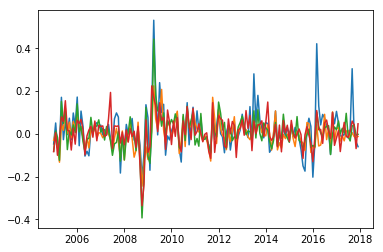

In [2]:
#for i in range(comparisonDF.shape[0]):
 
plt.plot(comparisonDF)
plt.show()
    